<a href="https://colab.research.google.com/github/sugengdcahyo/agent-rag/blob/main/02-reasoning-engine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deploying agent to reasoning engine

This notebook covers how we can restructure the agent code and ultimately deploy the agent to google vertex ai.

## Required Software Installed Locally

* Python version 3.9, 3.10, or 3.11. **Python3.12 will not work**.

* If you are using VSCode, please install Jupyter Notebook extensions.

* Jupyter notebook. Please follow this [installation guide](https://docs.jupyter.org/en/stable/install.html). You may choose whether you want to install classic jupyter notebook or jupyterlab (the next-gen web ui for jupyter)

    * [Classic jupyter notebook installation guide](https://docs.jupyter.org/en/stable/install/notebook-classic.html)

    * [Jupyterlab installation guide](https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html)

* Google Cloud CLI. Please follow this [installation guide](https://cloud.google.com/sdk/docs/install-sdk)

### Installing dependencies

In [2]:
%%writefile requirements.txt

google-cloud-aiplatform
google-cloud-aiplatform[langchain]
google-cloud-aiplatform[reasoningengine]
langchain
langchain_core
langchain_community
langchain-google-vertexai==2.0.8
cloudpickle
pydantic==2.9.2
langchain-google-community
google-cloud-discoveryengine
nest-asyncio
asyncio==3.4.3
asyncpg==0.29.0
cloud-sql-python-connector[asyncpg]
langchain-google-cloud-sql-pg
numpy
pandas
pgvector
psycopg2-binary
langchain-openai
langgraph
traceloop-sdk
opentelemetry-instrumentation-google-generativeai
opentelemetry-instrumentation-langchain
opentelemetry-instrumentation-vertexai
python-dotenv

Writing requirements.txt


In [2]:
!pip install --upgrade -r requirements.txt

  Using cached numpy-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached langgraph-0.3.2-py3-none-any.whl.metadata (17 kB)
  Using cached cloud_sql_python_connector-1.17.0-py3-none-any.whl.metadata (30 kB)
  Using cached dnspython-2.7.0-py3-none-any.whl.metadata (5.8 kB)
INFO: pip is looking at multiple versions of cloud-sql-python-connector[asyncpg] to determine which version is compatible with other requirements. This could take a while.
  Using cached cloud_sql_python_connector-1.16.0-py2.py3-none-any.whl.metadata (30 kB)
  Using cached cloud_sql_python_connector-1.15.0-py2.py3-none-any.whl.metadata (30 kB)
  Using cached cloud_sql_python_connector-1.14.0-py2.py3-none-any.whl.metadata (28 kB)


## Setting up Google Cloud Account

#### Recommended account setup

if you are running this in jupyter notebook locally, you may need to login to google cloud by running the following command from terminal:

```
gcloud auth login
gcloud auth application-default login
```

If you are using Google Colabs, you need to authenticate with your google account by running the following notebook cell.

> Please remember that you will need to do this on each jupyter notebook during this workshop

In [3]:
# #@markdown ###Authenticate your Google Cloud Account and enable APIs.
# # Authenticate gcloud.
from google.colab import auth
auth.authenticate_user()

In [ ]:
!gcloud projects list

In [4]:
import requests
from typing import Optional, List
from IPython.display import display, Markdown

from langchain.agents.format_scratchpad import format_to_openai_function_messages
from langchain.tools.retriever import create_retriever_tool
from langchain.pydantic_v1 import BaseModel, Field
from langchain.tools import StructuredTool
from langchain.memory import ChatMessageHistory
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_google_cloud_sql_pg import PostgresChatMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory

from langchain.prompts import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    MessagesPlaceholder,
    SystemMessagePromptTemplate,
)

from langchain_google_cloud_sql_pg import (
    PostgresEngine,
    PostgresVectorStore,
)

from vertexai.preview import reasoning_engines
from langchain_google_vertexai import VertexAIEmbeddings
from langchain_google_vertexai import HarmBlockThreshold, HarmCategory

/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py:3553: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
project_id = "agent-rag-451702"  # @param {type:"string"}
region = "us-central1" #change this to project location
# staging_bucket_name = "devfest24-demo-bucket"  # @param {type:"string"}
instance_name="mkrs-demo" # @param {type:"string"}
database_password = 'testing' # @param {type:"string"}
database_name = 'testing' # @param {type:"string"}
database_user = 'testing' # @param {type:"string"}

assert database_name, "⚠️ Please provide a database name"
assert database_user, "⚠️ Please provide a database user"
assert database_password, "⚠️ Please provide a database password"

# dont update variable below
!gcloud config set project {project_id} --quiet

# get the ip address of the cloudsql instance
ip_addresses = !gcloud sql instances describe {instance_name} --format="value(ipAddresses[0].ipAddress)"
database_host = ip_addresses[0]

gemini_embedding_model = "text-embedding-004"
gemini_llm_model = "gemini-2.0-flash-001"
embeddings_table_name = "course_content_embeddings"
chat_history_table_name = "chat_histories"

# print(f"API Base URL: {api_base_url}")
print(f"Database Host: {database_host}")

Updated property [core/project].
Database Host: 35.239.247.104


### Initializing vertex ai

In [6]:
import vertexai
vertexai.init(project=project_id, location=region)

### Agent Code

This section below define a few classes that we have tried from the previous notebook.

The main focus here should be `CourseAgent` where we setup all dependencies required by the agent

In [7]:
import psycopg2
import json


class CourseAPIClient:
    def __init__(self):
        """
        db_config: dictionary dengan keys: host, port, dbname, user, password
        """
        db_config = {
            "host": "lecture-dss-db.mekarsa.com",
            "port": 54321,
            "dbname": "warehouse",
            "user": "lecture2024",
            "password": "Ojolali123"
        }
        self.conn = psycopg2.connect(**db_config)
        self.cur = self.conn.cursor()

    def list_tax(self):
        """Mengambil daftar kursus dari database"""
        query = """SELECT
          fpd.kode_rekening,
          fpd.target_murni,
          fpd.totrealisasi_after,
          fpd.persentarget_all,
          dr.nama_rek
        FROM fact_pendapatan_daerah fpd
        join dim_rekening dr
        on fpd.kode_rekening = dr.kode_rekening;"""
        self.cur.execute(query)
        courses = self.cur.fetchall()
        self.close_connection()

        result = [{
            "fpd.kode_rekening": c[0],
            "fpd.terget_realita": float(c[1]),
            "fpd.totrealisasi_after": float(c[2]),
            "fpd.persetarget_all": float(c[3]),
            "dr.nama_rek": c[4]
          } for c in courses]
        return json.dumps(result)

    def get_tax(self, param):
        """Mengambil daftar kursus dari database"""
        query = f"""
        SELECT
          fpd.kode_rekening,
          fpd.target_murni,
          fpd.totrealisasi_after,
          fpd.persentarget_all,
          dr.nama_rek
        FROM
          fact_pendapatan_daerah fpd
        JOIN
          dim_rekening dr
        ON
          fpd.kode_rekening = dr.kode_rekening
        WHERE
          fpd.kode_rekening = '{param}' or
          dr.nama_rek like '%{param}%'"""
        self.cur.execute(query)
        courses = self.cur.fetchall()
        self.close_connection()

        result = [{
            "fpd.kode_rekening": c[0],
            "fpd.terget_realita": float(c[1]),
            "fpd.totrealisasi_after": float(c[2]),
            "fpd.persentarget_all": float(c[3]),
            "dr.nama_rek": c[4]
          } for c in courses]
        return json.dumps(result)

    def data_report(self, param):
      return "https://api.mekarsa.com/report/report-id"

    def ticket_summaries(self, param):
        """Mengambil daftar kursus dari database"""
        query = f"""
        SELECT
          sum(target_murni) as target,
          sum(totrealisasi_after) as realisasi,
          sum(persentarget_all) as percentage
        FROM fact_pendapatan_daerah fpd
        JOIN dim_rekening dr
        ON fpd.kode_rekening = dr.kode_rekening
        WHERE
          fpd.kode_rekening = '{param}' or dr.nama_rek like '%{param}%';"""
        self.cur.execute(query)
        courses = self.cur.fetchall()
        self.close_connection()

        result = [{
            "target": c[0],
            "realisasi": float(c[1]),
            "percentage": float(c[2])
          } for c in courses]
        return json.dumps(result)

    def close_connection(self):
        """Menutup koneksi ke database"""
        self.cur.close()
        self.conn.close()


In [8]:
api = CourseAPIClient()

In [9]:
api.list_tax()

'[{"fpd.kode_rekening": "4", "fpd.terget_realita": 4271590000000.0, "fpd.totrealisasi_after": 2871066126375.62, "fpd.persetarget_all": 67.2130547729445, "dr.nama_rek": "Pendapatan Daerah"}, {"fpd.kode_rekening": "4.1", "fpd.terget_realita": 771072268674.0, "fpd.totrealisasi_after": 554413320244.93, "fpd.persetarget_all": 71.90160284176027, "dr.nama_rek": "Pendapatan Asli Daerah"}, {"fpd.kode_rekening": "4.1.1", "fpd.terget_realita": 554860000000.0, "fpd.totrealisasi_after": 372499026684.39, "fpd.persetarget_all": 67.13387641646361, "dr.nama_rek": "Hasil Pajak Daerah"}, {"fpd.kode_rekening": "4.1.1.6", "fpd.terget_realita": 50000000000.0, "fpd.totrealisasi_after": 44641477501.46, "fpd.persetarget_all": 89.28295500291999, "dr.nama_rek": "Pajak Jasa Perhotelan"}, {"fpd.kode_rekening": "4.1.1.6.1", "fpd.terget_realita": 49129000000.0, "fpd.totrealisasi_after": 43028719101.46, "fpd.persetarget_all": 87.58313643969956, "dr.nama_rek": "Pajak Hotel"}, {"fpd.kode_rekening": "4.1.1.6.1.1", "fpd.

In [10]:
api = CourseAPIClient()
api.get_tax("4.1")

'[{"fpd.kode_rekening": "4.1", "fpd.terget_realita": 771072268674.0, "fpd.totrealisasi_after": 554413320244.93, "fpd.persentarget_all": 71.90160284176027, "dr.nama_rek": "Pendapatan Asli Daerah"}]'

In [11]:

class GetCourseInput(BaseModel):
    course: str = Field(description="name of the course. this is the unique identifier of the course. it typically contains the course title with dashes, all in lowercase.")

class GetOrderInput(BaseModel):
    order_number: str = Field(description="order number identifier. this is a unique identifier in uuid format.")

class CreateOrderInput(BaseModel):
    course: str = Field(description="name of the course. this is the unique identifier of the course. it typically contains the course title with dashes, all in lowercase.")
    user_name: str = Field(description="name of the user who is purchasing the course .")
    user_email: str = Field(description="email of the user who is purchasing the course.")

class CourseAgent(reasoning_engines.Queryable):
    def __init__(
        self,
        model: str,
        project: str,
        region: str,
        instance: str,
        database: str,
        table: str,
        user: Optional[str] = None,
        password: Optional[str] = None,

    ):
        self.model_name = model
        self.project = project
        self.region = region
        self.instance = instance
        self.database = database
        self.table = table
        self.user = user
        self.password = password
        self.store = {}
        self.agent = None
        self.retriever = None
        self.engine = None

    def __getstate__(self):
        """Custom method for pickling the object."""
        state = self.__dict__.copy()
        # Remove the unpicklable entries
        del state['agent']
        del state['retriever']
        del state['engine']
        return state

    def __setstate__(self, state):
        """Custom method for unpickling the object."""
        self.__dict__.update(state)
        self.agent = None
        self.retriever = None
        self.engine = None
        # Note: set_up() will need to be called after unpickling


    def list_tax(self) -> List[str]:
        """List all available courses sold on the platform."""
        client = CourseAPIClient()
        return client.list_tax()

    def get_course(self, param: str) -> str:
        """Get course details by course name. course name is the unique identifier of the course. it typically contains the course title with dashes.
        This function can be used to get course details such as course price, etc."""
        client = CourseAPIClient()
        return client.get_tax(param)

    def ticket_summaries(self, param: str) -> str:
        """Get course details by course name. course name is the unique identifier of the course. it typically contains the course title with dashes.
        This function can be used to get course details such as course price, etc."""
        client = CourseAPIClient()
        return client.ticket_summaries(param)

    def data_report(self, param: str) -> str:
        """Get course details by course name. course name is the unique identifier of the course. it typically contains the course title with dashes.
        This function can be used to get course details such as course price, etc."""
        client = CourseAPIClient()
        return client.data_report(param)

    def get_session_history(self, session_id: str) -> BaseChatMessageHistory:
        return PostgresChatMessageHistory.create_sync(
            self.engine,
            table_name=chat_history_table_name,
            session_id=session_id,
        )

    def set_up(self):
        """All unpickle-able logic should go here.
        In general, add any logic that requires a network or database
        connection.
        """

        #  we must initialize the Vertex AI client to use the right project and location
        # otherwise, when the agent is initialized in reasoning engine, it will use reasoning engine project
        vertexai.init(project=self.project, location=self.region)

        # Initialize the vector store
        self.engine = PostgresEngine.from_instance(
            self.project,
            self.region,
            self.instance,
            self.database,
            user=self.user,
            password=self.password,
            quota_project=self.project,
        )

        embeddings_service = VertexAIEmbeddings(model_name=gemini_embedding_model,
                                                project=self.project)

        vector_store = PostgresVectorStore.create_sync(
            self.engine,
            table_name=self.table,
            embedding_service=embeddings_service,
        )
        self.retriever = vector_store.as_retriever(search_kwargs={"k": 10})

        get_course = StructuredTool.from_function(
            func=self.get_course,
            name="get_course",
            description="Jelaskan rincian dari pendapatan atau pajak daerah.",
        )

        list_tax = StructuredTool.from_function(
            func=self.list_tax,
            name="list_tax",
            description="Daftar pendapatan daerah yang terkumpul.",
        )

        ticket_summaries = StructuredTool.from_function(
            func=self.ticket_summaries,
            name="ticket_summaries",
            description="Hitung jumlah pendapatan pada kelompok tiket tertentu."
        )

        data_report = StructuredTool.from_function(
            func=self.data_report,
            name="data_report",
            description="Buat file laporan."
        )

        tools = [get_course, list_tax]

        # Initialize the LLM and prompt
        prompt = {
            "chat_history": lambda x: x["history"],
            "input": lambda x: x["input"],
            "agent_scratchpad": (
                lambda x: format_to_openai_function_messages(x["intermediate_steps"])
            ),
        } | ChatPromptTemplate(
            messages = [
                SystemMessagePromptTemplate.from_template("""
                You are a bot assistant that sells online course about software security. You only use information provided from datastore or tools. You can provide the information that is relevant to the user's question or the summary of the content. If they ask about the content, you can give them more detail about the content. If the user seems interested, you may suggest the user to enroll in the course.
                """),
                MessagesPlaceholder(variable_name="chat_history", optional=True),
                HumanMessagePromptTemplate.from_template("Use tools to answer this questions: {input}"),
                MessagesPlaceholder(variable_name="agent_scratchpad"),
            ]
        )

        safety_settings = {
            HarmCategory.HARM_CATEGORY_UNSPECIFIED: HarmBlockThreshold.BLOCK_ONLY_HIGH,
            HarmCategory.HARM_CATEGORY_SEXUALLY_EXPLICIT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
            HarmCategory.HARM_CATEGORY_HARASSMENT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
            HarmCategory.HARM_CATEGORY_DANGEROUS_CONTENT: HarmBlockThreshold.BLOCK_ONLY_HIGH,
            HarmCategory.HARM_CATEGORY_HATE_SPEECH: HarmBlockThreshold.BLOCK_ONLY_HIGH,
        }

        ## Model parameters
        model_kwargs = {
            "temperature": 0.5,
            "safety_settings": safety_settings,
        }

        self.agent = reasoning_engines.LangchainAgent(
            model=self.model_name,
            tools=tools,
            prompt=prompt,
            chat_history=self.get_session_history,
            agent_executor_kwargs={
                "return_intermediate_steps": True,
            },
            model_kwargs=model_kwargs,
            enable_tracing=True,
        )
        print("agent is configured")


    def query(self, input: str, session_id: str) -> str:
        """Query the application.

        Args:
            input: The user query.
            session_id: The user's session id.

        Returns:
            The LLM response dictionary.
        """

        response = self.agent.query(
            input=input,
            config={"configurable": {"session_id": session_id}},
        )
        return response

### Instantiating the agent

In [51]:
agent = CourseAgent(
    model=gemini_llm_model,
    project=project_id,
    region=region,
    instance=instance_name,
    database=database_name,
    table=embeddings_table_name,
    user=database_user,
    password=database_password,
)
agent.set_up()

agent is configured


### Testing agent (again) locally

In [52]:
import uuid

# Generate a UUID for the session ID
session_id = str(uuid.uuid4())
print(f"Generated session ID: {session_id}")

Generated session ID: 9aba99ef-aa4c-4047-9182-aeac34753a6f


In [19]:
res = agent.query(
    input="data pendapatan apa saja yang kamu simpan?",
    session_id=session_id)

display(Markdown(res["output"]))

Berikut adalah daftar data pendapatan yang disimpan:
- Pendapatan Daerah
- Pendapatan Asli Daerah
- Hasil Pajak Daerah
- Pajak Jasa Perhotelan
- Pajak Hotel
- Hotel Bintang Lima
- Hotel Bintang Empat
- Hotel Bintang Tiga
- Hotel Bintang Dua
- Hotel Bintang Satu
- Hotel Melati Satu
- Pajak Motel
- Pajak Losmen
- Pajak Gubuk Pariwisata
- Pajak Wisma Pariwisata
- Pajak Pesanggrahan
- Pajak Pesanggrahan (Cotege)
- Pajak Rumah Penginapan dan Sejenisnya
- Pajak Rumah Kos dengan Jumlah Kamar Lebih dari 10 (Sepuluh)
- Pajak Hotel (Kost 11+)
- Pajak Hotel (Kost 20+)
- Pajak Makanan dan/atau Minuman
- Pajak Restoran
- Pajak Restoran dan Sejenisnya
- Pajak Rumah Makan dan Sejenisnya
- Pajak Kafetaria dan Sejenisnya
- Pajak Kantin dan Sejenisnya
- Pajak Warung dan Sejenisnya
- Pajak Bar dan Sejenisnya
- Pajak Jasa Boga/Katering dan Sejenisnya
- Pajak Jasa Kesenian dan Hiburan
- Pajak Tontonan Film
- Pajak Pagelaran Kesenian/Musik/Tari/Busana
- Pajak Kontes Kecantikan, Binaraga dan Sejenisnya
- Pajak Pameran
- Pajak Diskotik, Karoke, Klub Malam dan Sejenisnya
- Karaoke
- Klub Malam
- Pajak Sirkus/Akrobat/Sulap
- Pajak Permainan Biliar dan Bowling
- Pajak Pacuan Kuda, Kendaraan Bermotor dan Permainan Ketangkasan
- Balap Kendaraan Bermotor
- Permainan Ketangkasan
- Pajak Panti Pijat, Refleksi, Mandi Uap/Spa dan Pusat Kebugaran (Fitness Center)
- Panti Pijat/Refleksi
- Mandi Uap/Spa
- Spa Dalam Salon Kecantikan
- Pusat Kebugaran/Fitness Center
- Pajak Pertandingan Olahraga
- Pajak Rekreasi Wahana Air
- Pajak Rekreasi Wahana Ekologi
- Pajak Rekreasi Wahana Pendidikan
- Pajak Rekreasi Wahana Budaya
- Pajak Rekreasi Wahana Salju
- Pajak Rekreasi Wahana Permainan
- Pajak Pemancingan
- Pajak Argowisata
- Pajak Kebun Binatang
- Pajak Tempat Olah Raga Dan Kebugaran
- Pajak Reklame
- Pajak Reklame Papan/Billboard/Videotron/Megatron
- Pajak Reklame Kain
- Pajak Reklame Melekat/Stiker
- Pajak Reklame Selebaran
- Pajak Reklame Berjalan
- Pajak Reklame Udara
- Pajak Reklame Apung
- Pajak Reklame Suara
- Pajak Reklame Film/Slide
- Pajak Reklame Peragaan
- Pajak Tenaga Listrik
- Pajak Tenaga Listrik Dihasilkan Sendiri
- Pajak Tenaga Listrik Sumber Lain
- 01. Genset
- 02. Industri
- Pajak Parkir
- 01. Pusat Perbelanjaan/ Mall
- 02. Lain - lain
- 03. Cuma-Cuma
- Pajak Air Tanah
- Pajak Sarang Burung Walet
- Pajak Mineral Bukan Logam dan Batuan
- Pajak Mineral bukan Logam dan Batuan Lainnya
- Pajak Bumi dan Bangunan Perdesaan dan Perkotaan (PBBP2)
- PBB P2
- Bea Perolehan Hak Atas Tanah dan Bangunan (BPHTB)
- BPHTB - Pemindahan Hak
- BPHTB-Pemberian Hak Baru
- Hasil Retribusi Daerah
- Retribusi Jasa Umum
- Retribusi Pelayanan Kesehatan
- Retribusi Pelayanan Kesehatan di Puskesmas
- Pendapatan BLUD
- 01. RSUD IA. Moies
- 02. PUSKESMAS
- Retribusi Pelayanan Persampahan/ Kebersihan
- Retribusi Pelayanan Pemakaman dan Pengabuan Mayat
- Retribusi Pelayanan Penguburan/Pemakaman termasuk Penggalian dan Pengurukan serta Pembakaran/Pengabuan Mayat
- Retribusi Sewa Tempat Pemakaman atau Pembakaran/Pengabuan Mayat
- Retribusi Pelayanan Parkir di Tepi Jalan Umum
- Retribusi Penyediaan Pelayanan Parkir di Tepi Jalan Umum
- Retribusi Pelayanan Pasar
- Retribusi Pelayanan Pasar
- Retribusi Pengujian Kendaraan Bermotor
- Retribusi Pengujian Kendaraan Bermotor
- Retribusi Pengujian Kendaraan Bermotor Diatas Air
- Retribusi Pemeriksaan Alat Pemadam Kebakaran
- Retribusi Pelayanan Pemeriksaan dan/atau Pengujian Alat Pemadam Kebakaran
- Retribusi Pelayanan Pemeriksaan dan/atau Pengujian Alat Penanggulangan Kebakaran
- Retribusi Pelayanan Pemeriksaan dan/atau Pengujian Alat Penyelamatan Jiwa
- Retribusi Penggantian Biaya Cetak Peta
- Retribusi Penyediaan Peta Dasar (Garis)
- Retribusi Penyediaan Peta Foto
- Retribusi Penyediaan Peta Digital
- Retribusi Penyediaan Peta Tematik
- Retribusi Penyediaan Peta Teknis (Struktur)
- Retribusi Penyediaan dan/atau Penyedotan Kakus
- Retribusi Penyediaan dan/atau Penyedotan Kakus
- Retribusi Penyediaan dan/atau Penyedotan Kakus
- Retribusi Pengelolahan Limbah Cair
- Retribusi Rumah Tangga
- Retribusi Perkantoran
- Retribusi Industri
- Retribusi Pelayanan Tera/Tera Ulang
- Retribusi Pelayanan Pengujian Alat-Alat Ukur, Takar, Timbang, dan Perlengkapannya
- Retribusi Pengujian Barang dalam Keadaan Terbungkus
- Retribusi Pelayanan Pendidikan
- Retribusi Pelayanan Penyelenggaraan Pendidikan Teknis
- Retribusi Pelayanan Penyelenggaraan Pelatihan Teknis
- Retribusi Pelayanan Penyelenggaraan Pendidikan dan Pelatihan Teknis
- Retribusi Pengawasan dan Pengendalian Menara Telekomunikasi
- Retribusi Pengawasan dan Pengendalian Menara Telekomunikasi
- Retribusi Jasa Usaha
- Retribusi Pemakaian Kekayaan Daerah
- Retribusi Penyewaan Tanah dan Bangunan
- Retribusi Penyewaan Tanah
- 01.1 Sewa Tanah Milik Pemerintah/BPKAD
- 01.01 Sewa Tanah Milik Pemerintah/DISHUB
- 01.02.Retribusi Pemakaian Tanah Di Atas HPL Milik Pemkot Samarinda
- 01.03. Retribusi sewa kios/petak/los- Dinas Perdagangan
- Retribusi Penyewaan Bangunan
- 01. Gedung Olahraga Segiri
- 02. Sewa Lapangan Parkir Gedung Olahraga Segiri
- 03. Stadion Segiri
- 04. Sirkuit Kalan
- 05. Rumah Dinas
- * Pasar (Pemanfaatan Aset Daerah)
- Pendapatan Zakat
- Retribusi Pemakaian Laboratorium
- Retribusi Pemakaian Ruangan
- 01. Retr. Pemakaian Aset Daerah Berjualan Dalam Pasar (Disdag)
- Retribusi Pemakaian Kendaraan bermotor
- 01. Bus Besar
- 02. Bus Kecil
- Retribusi Pemakaian Alat
- 01. Alat Laboratorium/Pengujian
- 02. Alat Survey/Pengukuran
- 03. Alat Berat
- Retribusi Pasar Grosir dan/atau Perkotaan
- Retribusi Penyediaan Fasilitas Pasar Grosir Berbagai Jenis Barang yang Dikontrakkan
- Retribusi Penyediaan Fasilitas Pasar/Pertokoan yang Dikontrakkan
- Retribusi Tempat Pelelangan
- Retribusi Penyediaan Tempat Pelelangan
- Retribusi Penyediaan Fasilitas Lainnya di Tempat Pelelangan
- 01. Retribusi sandar Kapal (setiap sandar)
- 02. Pas Masuk untuk perorangan ke area kerja PPI (per Tahun)
- 03. Masuk untuk kendaraan ke area TPI (setiap kali masuk)
- 04. Pemakaian Fasilitas PPI untuk penjualan ikan (pendaratan ikan dan SIKPI)
- 05. Pemakaian Lokasi PPI untuk produksi es balok
- 06. Ret. Jasa Ruang Pendingin Ikan di PPI
- Retribusi Terminal
- Retribusi Pelayanan Penyediaan Tempat Parkir untuk Kendaraan Penumpang dan Bus Umum
- Retribusi Pelayanan Penyediaan Tempat Kegiatan Usaha
- Retribusi Pelayanan Penyediaan Fasilitas Lainnya di Lingkungan Terminal
- Retribusi Tempat Parkir Khusus
- Retribusi Pelayanan Tempat Khusus Parkir
- 01. Untuk Parkir Dalam Area Pasar/DISDAG
- 02. Untuk Taman Buah Bebaya/DISHUB
- 03. Untuk Parkir Gor Segiri-dishub
- 04. Untuk Parkir Gor Segiri-dispora
- 05. Untuk Parkir Plaza 21
- 06. Untuk Parkir Pasar-Pasar
- 07. Untuk Parkir RSUD IA MOEIS
- 08. Untuk Parkir Pasar Merdeka
- 09. Untuk Parkir Pasar Sungai Dama
- 10. Untuk Parkir Taman Samarendah
- 11. Untuk Parkir Pasar Baqa
- Retribusi Tempat Penginapan/ Pesanggrahan/Vila
- Retribusi Pelayanan Tempat Penginapan/ Pesanggrahan/Vila
- 01. Mess Perwakilan Samarinda di Jakarta
- Retribusi Rumah Potong Hewan
- Retribusi Pelayanan Rumah Potong Hewan
- 01. Pemeriksaan Kesehatan Hewan di Rumah Pemotongan Hewan
- 02. Pemeriksaan Kesehatan Unggas dan/atau Daging Unggas di RPH
- 03. Pengandangan di RPH
- Pelayanan Kesehatan untuk Hewan Ternak
- Retribusi Pelayanan Kepelabuhanan
- Retribusi Pelayanan Kepelabuhanan
- 01. Laut
- 01.1 Pelayanan Kapal
- 01.2 Pelayanan Barang
- 01.3 Pelayanan Lainnya
- 02. Angkutan Sungai
- 02.1 Tambat Kapal
- 02.2 Tarif Masuk Dermaga
- 02.3 Lain - lain (mck,wc,kios,toko)
- 02.4 Tarif Masuk Dermaga S. Kunjang
- 02.5 Tarif Masuk Dermaga Pasar Pagi
- 02.5 Tarif Masuk Dermaga Harapan Baru
- 02.5 Tarif Masuk Dermaga Samarinda Seberang
- 02.6 Tarif Masuk Dermaga Loa Janan
- Retribusi Tempat Rekreasi dan Olahraga
- Retribusi Pelayanan Tempat Rekreasi dan Olahraga
- Retribusi Penyebrangan di Air
- Retribusi Pelayanan Penyeberangan Orang
- Retribusi Pelayanan Penyeberangan Barang
- Retribusi Penjualan Produksi Usaha Daerah
- Retribusi Penjualan Produksi Hasil Usaha Daerah berupa Bibit atau Benih Tanaman
- Retribusi Penjualan Produksi hasil Usaha Daerah berupa Bibit Ternak
- Retribusi Penjualan Produksi hasil Usaha Daerah berupa Bibit atau Benih Ikan
- Retribusi Penjualan Produksi hasil Usaha Daerah selain Bibit atau Benih Tanaman, Ternak, dan Ikan
- Retribusi Perizinan Tertentu
- Retribusi Izin Mendirikan Bangunan
- Retribusi Pemberian Izin Mendirikan Bangunan
- Retribusi Izin Tempat Penjualan Minuman Beralkohol
- Retribusi Pemberian Izin Tempat Penjualan Minuman Beralkohol
- Retribusi Izin Trayek untuk Menyediakan Pelayanan Angkutan Umum
- Retribusi Izin Trayek untuk Menyediakan Pelayanan Angkutan Umum
- Retribusi Izin Usaha Perikanan
- Retribusi Pemberian Izin Kegiatan Usaha Penangkapan Ikan
- Retribusi Pemberian Izin Kegiatan Usaha Pembudidayaan Ikan
- Retribusi Pengendalian Lalu Lintas
- Retribusi Pengendalian Lalu Lintas Penggunaan Ruas Jalan Tertentu
- Retribusi Pengendalian Lalu Lintas Penggunaan Koridor Tertentu
- Retribusi Pengendalian Lalu Lintas Penggunaan Kawasan Tertentu
- Retribusi Perpanjangan Izin Mempekerjakan Tenaga Kerja Asing (IMTA)
- Retribusi Pemberian Perpanjangan IMTA kepada Pemberi Kerja Tenaga Kerja Asing
- Hasil Pengelolaan Kekayaan Daerah yang Dipisahkan
- Bagian Laba yang Dibagikan kepada Pemerintah Daerah (Dividen) atas Penyertaan Modal pada BUMN
- Bagian Laba yang Dibagikan kepada Pemerintah Daerah (Dividen) atas Penyertaan Modal pada BUMD
- Hasil Selisih Lebih Tukar Menukar Jalan dan Jembatan
- Bagian Laba yang Dibagikan kepada Pemerintah Daerah (Dividen) atas Penyertaan Modal pada BUMD (Lembaga Keuangan)
- Bagian Laba yang Dibagikan kepada Pemerintah Daerah (Dividen) atas Penyertaan Modal pada BUMD (Lembaga Keuangan)
- 01. Bankaltim
- 02. Bank Perkreditan Rakyat (BPR) Kota Samarinda
- Bagian Laba yang Dibagikan kepada Pemerintah Daerah (Dividen) atas Penyertaan Modal pada BUMD (Varian Niaga)
- Bagian Laba yang Dibagikan kepada Pemerintah Daerah (Dividen) atas Penyertaan Modal pada BUMD (Varian Niaga)
- Bagian Laba yang Dibagikan kepada Pemerintah Daerah (Dividen) atas Penyertaan Modal pada BUMD (Bidang Air Minum)
- Bagian Laba yang Dibagikan kepada Pemerintah Daerah (Dividen) atas Penyertaan Modal pada Perusahaan Milik Daerah/BUMD (Bidang Air Minum)
- 01. Perusahaan Daerah Air Minum (PDAM)
- Bagian Laba yang Dibagikan kepada Pemerintah Daerah (Dividen) atas Penyertaan Modal pada BUMD (Bidang Limbah)
- Bagian Laba yang Dibagikan kepada Pemerintah Daerah (Dividen) atas Penyertaan Modal pada BUMD (Bidang Limbah)
- Bagian Laba yang Dibagikan kepada Pemerintah Daerah (Dividen) atas Penyertaan Modal pada BUMD (Bidang Sanitasi)
- Bagian Laba yang Dibagikan kepada Pemerintah Daerah (Dividen) atas Penyertaan Modal pada BUMD (Bidang Sanitasi)
- Bagian Laba yang dibagikan kepada Pemerintah Daerah (Dividen) atas Penyertaan Modal pada Perusahaan Milik Swasta
- Bagian Laba yang Dibagikan kepada Pemerintah Daerah (Dividen) atas Penyertaan Modal pada Perusahaan Milik Swasta
- Bagian Laba yang Dibagikan kepada Pemerintah Daerah (Dividen) atas Penyertaan Modal pada Perusahaan Milik Swasta
- Lain-lain Pendapatan Asli Daerah yang Sah
- Hasil Penjualan BMD yang Tidak Dipisahkan
- Hasil Penjualan Tanah
- Hasil Penjualan Tanah Digunakan untuk mencatat pendapatan dari hasil penjualan atas tanah.
- Hasil Penjualan Peralatan dan Mesin
- Hasil Penjualan Alat Besar
- Hasil Penjualan Alat Angkutan
- Hasil Penjualan Alat Bengkel dan Alat Ukur
- Hasil Penjualan Alat Pertanian
- Hasil Penjualan Alat Kantor dan Rumah Tangga
- Hasil Penjualan Alat Studio, Komunikasi, dan Pemancar
- Hasil Penjualan Alat Kedokteran dan Kesehatan
- Hasil Penjualan Alat Laboratorium
- Hasil Penjualan Komputer
- Hasil Penjualan Alat Eksplorasi
- Hasil Penjualan Alat Pengeboran
- Hasil Penjualan Alat Produksi, Pengolahan, dan Pemurnian
- Hasil Penjualan Alat Bantu Eksplorasi
- Hasil Penjualan Alat Keselamatan Kerja
- Hasil Penjualan Alat Peraga
- Hasil Penjualan Peralatan Proses/Produksi
- Hasil Penjualan Rambu-rambu
- Hasil Penjualan Peralatan Olahraga
- Hasil Penjualan Gedung dan Bangunan
- Hasil Penjualan Gedung dan Bangunan
- 02.Pendapatan Dari Angsuran/ Cicilan Penjualan
- Angsuran/Cicilan Penjualan Rumah Dinas Daerah Golongan III
- 01. Pokok Angsuran / Cicilan Penjualan Rumah Dinas Daerah Gol III
- 02. Denda Angsuran / Cicilan Penjualan Rumah Dinas Daerah Gol III
- Angsuran/Cicilan Penjualan Kendaraan Perorangan Dinas
- 01. Pokok Angsuran/Cicilan Penjualan Kendaraan Perorangan Dinas
- 02. Denda Angsuran/Cicilan Penjualan Kendaraan Perorangan Dinas
- Angsuran/Cicilan Ganti Kerugian Barang Milik Daerah
- 01. Pokok Angsuran/Cicilan Ganti Kerugian Barang Milik Daerah
- 02. Denda Angsuran/Cicilan Ganti Kerugian Barang Milik Daerah
- Angsuran/Cicilan Rumah Susun
- 01. Pokok Angsuran/Cicilan Rumah Susun
- 02. Denda Angsuran/Cicilan Rumah Susun
- Hasil Penjualan Monumen
- Hasil Penjualan Bangunan Menara
- Hasil Penjualan Tugu Titik Kontrol/Pasti
- Hasil Penjualan Jalan, Jaringan, dan Irigasi
- Hasil Penjualan Jalan dan Jembatan
- Hasil Penjualan Jalan dan Jembatan
- Hasil Penjualan Instalasi
- Hasil Penjualan Jaringan
- Hasil Penjualan Aset Tetap Lainnya
- Hasil Penjualan Bahan Perpustakaan
- Hasil Penjualan Barang Bercorak Kesenian/Kebudayaan/Olahraga
- Hasil Penjualan Hewan
- Hasil Penjualan Biota Perairan
- Hasil Penjualan Tanaman
- Hasil Penjualan Barang Koleksi Non Budaya
- Hasil Penjualan Aset Tetap Dalam Renovasi
- Hasil Penjualan Aset Lainnya
- Hasil Penjualan Aset Lainnya
- Hasil Selisih Lebih Tukar Menukar BMD yang Tidak Dipisahkan
- Hasil Selisih Lebih Tukar Menukar Tanah
- Hasil Selisih Lebih Tukar Menukar Tanah
- Hasil Selisih Lebih Tukar Menukar Peralatan dan Mesin
- Hasil Selisih Lebih Tukar Menukar Alat Besar
- Hasil Selisih Lebih Tukar Menukar Alat Angkutan
- Hasil Selisih Lebih Tukar Menukar Alat Bengkel dan Alat Ukur
- Hasil Selisih Lebih Tukar Menukar Alat Pertanian
- Hasil Selisih Lebih Tukar Menukar Alat Pertanian
- Hasil Selisih Lebih Tukar Menukar Alat Studio, Komunikasi, dan Pemancar
- Hasil Selisih Lebih Tukar Menukar Alat Kedokteran dan Kesehatan
- Hasil Selisih Lebih Tukar Menukar Alat Laboratorium
- Hasil Selisih Lebih Tukar Menukar Komputer
- Hasil Selisih Lebih Tukar Menukar Alat Eksplorasi
- Hasil Selisih Lebih Tukar Menukar Alat Pengeboran
- Hasil Selisih Lebih Tukar Menukar Alat Produksi, Pengolahan, dan Pemurnian
- Hasil Selisih Lebih Tukar Menukar Alat Bantu Eksplorasi
- Hasil Selisih Lebih Tukar Menukar Alat Keselamatan Kerja
- Hasil Selisih Lebih Tukar Menukar Alat Peraga
- Hasil Selisih Lebih Tukar Menukar Peralatan Proses/Produksi
- Hasil Selisih Lebih Tukar Menukar Rambu\u0002Rambu
- Hasil Selisih Lebih Tukar Menukar Peralatan Olahraga
- Hasil Selisih Lebih Tukar Menukar Gedung dan Bangunan
- Hasil Selisih Lebih Tukar Menukar Bangunan Gedung
- Hasil Selisih Lebih Tukar Menukar Monumen
- Hasil Selisih Lebih Tukar Menukar Bangunan Menara
- Hasil Selisih Lebih Tukar Menukar Tugu Titik Kontrol/Pasti
- Hasil Selisih Lebih Tukar Menukar Jalan, Jaringan, dan Irigasi
- Hasil Selisih Lebih Tukar Menukar Bangunan Air
- Hasil Selisih Lebih Tukar Menukar Instalasi
- Hasil Selisih Lebih Tukar Menukar Jaringan
- Hasil Selisih Lebih Tukar Menukar Aset Tetap Lainnya
- Hasil Selisih Lebih Tukar Menukar Bahan Perpustakaan
- Hasil Selisih Lebih Tukar Menukar Barang Bercorak Kesenian/Kebudayaan/Olahraga
- Hasil Selisih Lebih Tukar Menukar Barang Bercorak Kesenian/Kebudayaan/Olahraga
- Hasil Selisih Lebih Tukar Menukar Biota Perairan
- Hasil Selisih Lebih Tukar Menukar Tanaman
- Hasil Selisih Lebih Tukar Menukar Barang Koleksi Non Budaya
- Hasil Selisih Lebih Tukar Menukar Aset Tetap Dalam Renovasi
- Hasil Selisih Lebih Tukar Menukar Aset Lainnya
- Hasil Selisih Lebih Tukar Menukar Aset Lainnya-Aset Tidak Berwujud
- Hasil Selisih Lebih Tukar Menukar Aset Lainnya-Aset Lain-Lain
- Hasil Pemanfaatan BMD yang Tidak Dipisahkan
- Hasil Sewa BMD
- Hasil Sewa BMD
- Hasil Kerja Sama Pemanfaatan BMD
- Hasil Kerja Sama Pemanfaatan BMD
- Hasil dari Bangun Guna Serah
- Hasil dari Bangun Guna Serah
- Hasil dari Bangun Serah Guna
- Hasil dari Bangun Serah Guna
- Hasil dari Kerja Sama Penyediaan Infrastruktur
- Hasil dari Kerja Sama Penyediaan Infrastruktur
- Hasil Kerja Sama Daerah
- Hasil Kerja Sama Daerah
- Hasil Kerja Sama Daerah
- 01. PT. Samaco (Mahakam Lampion Garden)
- 03. PT. Pelabuhan Samudera Palaran (PSP)
- 04. PT. Wahana Abadi Tirtateknilka Sejati (WATS)
- 02. PERUSAHAAN PATUNGAN
- a. Pasar Segiri (PT. Yudha Putera Kaltim)
- b. Pasar Sungai Dama (PT. Surya Rizky Reza Jaya Abadi)
- c. Pasar Kedondong (PT. Bahana Surya Sentosa)
- d. Pasar Pagi (PT. Buluh Perindu)
- Jasa Giro
- Jasa Giro pada Kas Daerah
- Jasa Giro pada Kas Daerah
- Jasa Giro pada Kas di Bendahara
- Jasa Giro pada Kas di Bendahara
- Jasa Giro pada Rekening Dana Cadangan
- Jasa Giro pada Rekening Dana Cadangan
- Jasa Giro pada Rekening Dana BOS
- Jasa Giro pada Rekening Dana BOS
- Jasa Giro Dana Kapitasi pada FKTP
- Jasa Giro Dana Kapitasi pada FKTP
- Hasil Pengelolaan Dana Bergulir
- Hasil Pengelolaan Dana Bergulir
- Hasil Pengelolaan Dana Bergulir
- Pendapatan Bunga
- Pendapatan Bunga atas Penempatan Uang Pemerintah Daerah
- Pendapatan Bunga atas Penempatan Uang Pemerintah Daerah
- Pendapatan Zakat, Infaq, Shadaqah, dan Wakaf
- Penerimaan atas Tuntutan Ganti Kerugian Keuangan Daerah
- Tuntutan Ganti Kerugian Daerah terhadap Bendahara
- Tuntutan Ganti Kerugian Daerah terhadap Bendahara
- Tuntutan Ganti Kerugian Daerah terhadap Pegawai Negeri Bukan Bendahara atau Pejabat Lain
- Tuntutan Ganti Kerugian Daerah terhadap Pegawai Negeri Bukan Bendahara atau Pejabat Lain
- Penerimaan Komisi, Potongan, atau Bentuk Lain
- Penerimaan Komisi, Potongan, atau Bentuk Lain
- Penerimaan Komisi, Potongan, atau Bentuk Lain
- 01. Penerimaan Lain-Lain (Lebih Bayar Pendapatan Pajak / Retribusi atau penerimaan PAD Lain-lainnya)
- Penerimaan Keuntungan dari Selisih Nilai Tukar Rupiah terhadap Mata Uang Asing
- Penerimaan Keuntungan dari Selisih Nilai Tukar Rupiah terhadap Mata Uang Asing
- Penerimaan Keuntungan dari Selisih Nilai Tukar Rupiah terhadap Mata Uang Asing
- Pendapatan Denda atas Keterlambatan Pelaksanaan Pekerjaan
- Pendapatan Denda atas Keterlambatan Pelaksanaan Pekerjaan
- Pendapatan Denda atas Keterlambatan Pelaksanaan Pekerjaan
- Pendapatan Denda Pajak Daerah
- Pendapatan Denda Pajak Hotel
- Pendapatan Denda Pajak Hotel
- Pendapatan Denda Pajak Restoran
- Pendapatan Denda Pajak Restoran dan Sejenisnya
- Pendapatan Denda Pajak Hiburan
- Pendapatan Denda Pajak Hiburan dan Sejenisnya
- Pendapatan Denda Pajak Reklame
- Pendapatan Denda Pajak Reklame dan Sejenisnya
- Pendapatan Denda Pajak Tenaga Listrik
- Pendapatan Denda Pajak Tenaga Listrik
- Pendapatan Denda Pajak Parkir
- Pendapatan Denda Pajak Parkir
- Pendapatan Denda Pajak Air Tanah
- Pendapatan Denda Pajak Air Tanah
- Pendapatan Denda Pajak Sarang Burung
- Walet
- Pendapatan Denda Pajak Sarang Burung Walet
- Pendapatan Denda Pajak Mineral Bukan Logam dan Batuan
- Pendapatan Denda Pajak Mineral Bukan Logam dan Batuan
- Pendapatan Denda Pajak Bumi dan Bangunan Perdesaan dan Perkotaan (PBBP2)
- Pendapatan Denda PBBP2
- Pendapatan Denda Bea Perolehan Hak atas Tanah dan Bangunan (BPHTB)
- Pendapatan Denda BPHTB-Pemindahan Hak
- Pendapatan Denda BPHTB-Pemberian Hak Baru
- Pendapatan Denda Retribusi Daerah
- Pendapatan Denda Retribusi Jasa Umum
- Pendapatan Denda Retribusi Jasa Umum
- Pendapatan Denda Retribusi Jasa Usaha
- Pendapatan Denda Retribusi Jasa Usaha
- Pendapatan Denda Retribusi Perizinan Tertentu
- Pendapatan Denda Retribusi Izin Mendirikan Bangunan
- Pendapatan Zakat
- Pendapatan Denda Retribusi Izin Tempat Penjualan Minuman Beralkohol
- Pendapatan Denda Retribusi Izin Tempat Penjualan Minuman Beralkohol
- Pendapatan Denda Retribusi Izin Usaha Perikanan
- Pendapatan Denda Retribusi Pengendalian Lalu Lintas
- Pendapatan Denda Retribusi Perpanjangan Izin Mempekerjakan Tenaga Kerja Asing (IMTA)
- Pendapatan Hasil Eksekusi atas Jaminan
- Pendapatan dari Pengembalian
- Pendapatan dari Pengembalian Kelebihan Pembayaran Pajak Penghasilan Pasal 21
- Pendapatan dari Pengembalian Kelebihan Pembayaran Pajak Penghasilan Pasal 21
- Pendapatan dari Pengembalian Kelebihan Pembayaran Iuran Simpanan Peserta Tabungan Perumahan Rakyat ASN
- Pendapatan dari Pengembalian Kelebihan Pembayaran Iuran Simpanan Peserta Tabungan Perumahan Rakyat PNS
- Pendapatan dari Pengembalian Kelebihan Pembayaran Iuran Simpanan Peserta Tabungan Perumahan Rakyat PPPK
- Pendapatan dari Pengembalian Kelebihan Pembayaran Gaji dan Tunjangan
- Pendapatan dari Pengembalian Kelebihan Pembayaran Gaji dan Tunjangan
- Pendapatan dari Pengembalian Kelebihan Pembayaran Perjalanan Dinas
- Pendapatan dari Pengembalian Kelebihan Pembayaran Perjalanan Dinas Dalam Negeri Perjalanan Dinas Bia
- Pendapatan dari Pengembalian Kelebihan Pembayaran Perjalanan Dinas Dalam Negeri Perjalanan Dinas Tetap
- Pendapatan dari Pengembalian Kelebihan Pembayaran Perjalanan Dinas Dalam Negeri Perjalanan Dinas Dalam Kot
- Pendapatan dari Pengembalian Kelebihan Pembayaran Perjalanan Dinas Dalam Negeri Perjalanan Dinas Paket Meeting Dalam Kot
- Pendapatan dari Pengembalian Kelebihan Pembayaran Perjalanan Dinas Dalam Negeri Perjalanan Dinas Paket Meeting Luar Kota
- Pendapatan dari Pengembalian Kelebihan Pembayaran Perjalanan Dinas Luar Negeri Perjalanan Dinas Biasa–Luar Neg
- Pendapatan dari Pengembalian Kelebihan Pembayaran Kecelakaan Kerja (JKK)
- Pendapatan dari Pengembalian Kelebihan Pembayaran JKK
- Pendapatan dari Pengembalian Kelebihan Pembayaran Jaminan Kematian (JKM)
- Pendapatan dari Pengembalian Kelebihan Pembayaran JKM
- Pendapatan dari Pengembalian Kelebihan Pembayaran Jaminan Kesehatan Nasional (JKN)
- Pendapatan dari Pengembalian Kelebihan Pembayaran Jaminan Kesehatan Nasional (JKN)
- Pendapatan Denda Pemanfaatan BMD yang tidak Dipisahkan
- Pendapatan Denda Pengakhiran Sewa BMD
- Pendapatan Denda Pengakhiran Sewa BMD
- Pendapatan Denda Hasil dari Kerja Sama Penyediaan Infrastruktur
- Pendapatan Denda Hasil dari Kerja Sama Penyediaan Infrastruktur
- Pendapatan Dana Kapitasi Jaminan Kesehatan Nasional (JKN) pada Fasilitas Kesehatan Tingkat Pertama (FKTP)
- Pendapatan Dana Kapitasi JKN pada FKTP
- Pendapatan Dana Kapitasi JKN pada FKTP
- Pendapatan Hasil Pengelolaan Dana Bergulir
- Pendapatan Hasil Pengelolaan Dana Bergulir
- Pendapatan Hasil Pengelolaan Dana Bergulir
- Pendapatan Berdasarkan Putusan Pengadilan (Inkracht)
- Pendapatan Berdasarkan Putusan Pengadilan (Inkracht)
- Pendapatan Berdasarkan Putusan Pengadilan (Inkracht)
- Pendapatan Denda atas Pelanggaran Peraturan Daerah
- Pendapatan Denda atas Pelanggaran Peraturan Daerah
- Pendapatan Denda atas Pelanggaran Peraturan Daerah
- Pendapatan Infaq
- Pendapatan Shadaqah
- Pendapatan Wakaf
- Pendapatan Transfer
- Pendapatan Transfer Pemerintah Pusat
- Dana Perimbangan
- Dana Transfer Umum-Dana Bagi Hasil (DBH)
- DBH Pajak Bumi dan Bangunan
- 01. PBB Pertambangan (P3)
- 01.1. PBB Non Migas
- 01.2. PBB Migas
- 01.3.PBB Sektor Lainnya
- 01.4. Pemungutan PBB Migas
- 01.5. Pemungutan PBB Non Migas
- 01.6. Pemungutan Sektor Lainnya
- 01.7. Bagi Rata-rata
- 01.8. Pelimpahan PBB
- 01.9.PBB Perkebunan
- 01.10. PBB Kehutanan
- DBH PPh Pasal 21
- DBH PPh Pasal 25 dan Pasal 29/WPOPDN
- DBH Cukai Hasil Tembakau (CHT)
- DBH Sumber Daya Alam (SDA) Minyak Bumi
- DBH Sumber Daya Alam (SDA) Gas Bumi
- DBH Sumber Daya Alam (SDA) Pengusahaan Panas Bumi
- DBH Sumber Daya Alam (SDA) Mineral dan Batubara-Landrent
- Dana Bagi Hasil (DBH) Sumber Daya Alam (SDA) Mineral dan Batubara-Royalty
- DBH Sumber Daya Alam (SDA) Kehutanan Provisi Sumber Daya Hutan (PSDH)
- DBH Sumber Daya Alam (SDA) Kehutanan Iuran Izin Usaha Pemanfaatan Hutan (IIUPH)
- DBH Sumber Daya Alam (SDA) Kehutanan Dana Reboisasi (DR)
- DBH Sumber Daya Alam (SDA) Perikanan
- DBH Lainnya - Sawit
- Dana Transfer Umum-Dana Alokasi Umum (DAU)
- DAU
- DAU yang Tidak Ditentukan Penggunaannya
- DAU Tambahan Dukungan Pendanaan Kelurahan
- DAU Tambahan Dukungan Pendanaan atas Kebijakan Penyetaraan Penghasilan Tetap Kepala Desa dan Perangkat Desa
- DAU Tambahan Dukungan Pendanaan atas Kebijakan Penggajian Pegawai Pemerintah dengan Perjanjian Kerja
- DAU Tambahan Dukungan Pendanaan atas Kebijakan Penggajian Pegawai Pemerintah dengan Perjanjian Kerja
- Bidang Pendidikan
- Bidang Kesehatan
- Bidang Pekerjaan Umum
- Dana Transfer Khusus-Dana Alokasi Khusus (DAK) Fisik
- DAK Fisik-Bidang Pendidikan-Reguler-PAUD
- DAK Fisik-Bidang Pendidikan-Reguler-SD
- DAK Fisik-Bidang Pendidikan-Reguler-SMP
- DAK Fisik-Bidang Pendidikan-Reguler-SMA
- DAK Fisik-Bidang Pendidikan-Reguler-SLB
- DAK Fisik-Bidang Pendidikan-Reguler-SKB
- DAK Fisik-Bidang Pendidikan-Afirmasi-SD
- DAK Fisik-Bidang Pendidikan-Afirmasi-SMP
- DAK Fisik-Bidang Pendidikan-Afirmasi-SMA
- DAK Fisik-Bidang Pendidikan-Penugasan SMK
- DAK Fisik-Bidang Pendidikan-Reguler Perpustakaan Daerah
- DAK Fisik-Bidang Pendidikan-Reguler Gedung Olahraga
- DAK Fisik-Bidang Kesehatan dan KB Reguler-Pelayanan Kesehaan Dasar
- DAK Fisik-Bidang Kesehatan dan KB Reguler-Pelayanan Kesehatan Rujukn
- DAK Fisik-Bidang Kesehatan dan KB Reguler-Pelayanan Kefarmasin
- DAK Fisik-Bidang Kesehatan dan KB Penugasan-Penurunan Angka Kematian Ibu (AKI), Angka Kematian Bayi (AKB) dan Intervesi Stunting
- DAK Fisik-Bidang Kesehatan dan KB Penugasan-Penguatan Intervensi Stunting
- Fisik-Bidang Kesehatan dan KB Penugasan-Peningkatan Pencegahan dan
Pengendalian Penyakit dan Sanitasi Total
Berbasis Masyarakat
- DAK Fisik-Bidang Kesehatan dan KB Penugasan-Penguatan RS Rujukan
Nasional/Provinsi/Regional/Pariwisata
- DAK Fisik-Bidang Kesehatan dan KB Penugasan-Pembangunan RS Pratama
- DAK Fisik-Bidang Kesehatan dan KB Penugasan-Puskesmas Pariwisata
- DAK Fisik-Bidang Kesehatan dan KB Penugasan-Balai Pelatihan Kesehatan
- DAK Fisik-Bidang Kesehatan dan KB Afirmasi-Penguatan Puskesmas Daerah Tertinggal Perbatasan Negara dan Kepulauan (DTPK)
- DAK Fisik-Bidang Kesehatan dan KB Afirmasi-Penguatan Prasarana Dasar Puskesmas
- DAK Fisik-Bidang Kesehatan dan KB Reguler-KB
- DAK Fisik-Bidang Kesehatan dan KB Penugasan-Penurunan Stunting (KB)
- DAK Fisik-Bidang Perumahan dan Permukiman-Reguler-Penyediaan Rumah Swadaya
- DAK Fisik-Bidang Perumahan dan Permukiman-Afirmasi-Penyediaan Rumah Swadaya
- DAK Fisik-Bidang Perumahan dan Permukiman-Afirmasi-Penyediaan Rumah Khusus
- DAK Fisik-Bidang Industri Kecil dan Menengah-Penugasan-Pembangunan Sentra IKM dan Revitalisasi Sentra IKM
- DAK Fisik-Bidang Pertanian-Penugasan-Pembangunan/Renovasi Sarana dan
Prasarana Fisik Dasar Pembangunan Pertanian
- DAK Fisik-Bidang Kelautan dan Perikanan Penugasan
- DAK Fisik-Bidang Pariwisata-Penugasan
- DAK Fisik-Bidang Jalan-Reguler-Jalan
- DAK Fisik-Bidang Jalan-Penugasan-Jalan


In [20]:
response = agent.query(
    input="kelompokkan data berdasarkan rekening level 3?",
    session_id=session_id)
display(Markdown(response["output"]))

Tentu, berikut adalah data pendapatan yang dikelompokkan berdasarkan rekening level 3:

*   **4.1.1 Hasil Pajak Daerah**
*   **4.1.2 Hasil Retribusi Daerah**
*   **4.1.3 Hasil Pengelolaan Kekayaan Daerah yang Dipisahkan**
*   **4.1.4 Lain-lain Pendapatan Asli Daerah yang Sah**
*   **4.2.1 Pendapatan Transfer Pemerintah Pusat**
*   **4.2.2 Pendapatan Transfer Antar Daerah**
*   **4.3.1 Pendapatan Hibah**
*   **4.3.2 Dana Darurat**
*   **4.3.3 Lain-lain Pendapatan Sesuai dengan Ketentuan Peraturan Perundang-Undangan**

Apakah ada informasi lain yang ingin Anda ketahui?

In [22]:
response = agent.query(
    input="tampilkan rekening dan nilai angka pada rekening hasil retribusi daerah?",
    session_id=session_id)
display(Markdown(response["output"]))

Berikut adalah rincian rekening dan nilai angka pada rekening Hasil Retribusi Daerah:

*   **Kode Rekening:** 4.1.2
*   **Target Realisasi:** Rp 150.557.778.000,00
*   **Total Realisasi (Setelah):** Rp 105.813.856.641,03
*   **Persentase Target:** 70.28%
*   **Nama Rekening:** Hasil Retribusi Daerah

In [27]:
response = agent.query(
    input="berikan list data lengkap pendapatan 5 saja, hanya data lengkap pada kode rekening level 3?",
    session_id=session_id)
display(Markdown(response["output"]))

Tentu, berikut adalah 5 data pendapatan dengan kode rekening level 3 beserta detailnya:

1.  **Hasil Pajak Daerah**
    *   Kode Rekening: 4.1.1
    *   Target Realisasi: Rp 554.860.000.000,00
    *   Total Realisasi: Rp 372.499.026.684,39
    *   Persentase Target: 67.13%

2.  **Hasil Retribusi Daerah**
    *   Kode Rekening: 4.1.2
    *   Target Realisasi: Rp 150.557.778.000,00
    *   Total Realisasi: Rp 105.813.856.641,03
    *   Persentase Target: 70.28%

3.  **Hasil Pengelolaan Kekayaan Daerah yang Dipisahkan**
    *   Kode Rekening: 4.1.3
    *   Target Realisasi: Rp 20.290.129.000,00
    *   Total Realisasi: Rp 21.912.018.474,00
    *   Persentase Target: 107.99%

4.  **Lain-lain Pendapatan Asli Daerah yang Sah**
    *   Kode Rekening: 4.1.4
    *   Target Realisasi: Rp 45.364.361.674,00
    *   Total Realisasi: Rp 54.188.418.445,51
    *   Persentase Target: 119.45%

5.  **Pendapatan Transfer Pemerintah Pusat**
    *   Kode Rekening: 4.2.1
    *   Target Realisasi: Rp 2.288.257.908.000,00
    *   Total Realisasi: Rp 1.533.708.179.068,00
    *   Persentase Target: 67.03%


In [28]:
response = agent.query(
    input="5 data yang memiliki target realisasi tertinggi?",
    session_id=session_id)
display(Markdown(response["output"]))

Berikut adalah 5 data pendapatan dengan target realisasi tertinggi:

1.  **Pendapatan Daerah**
    *   Kode Rekening: 4
    *   Target Realisasi: Rp 4.271.590.000.000,00

2.  **Pendapatan Transfer**
    *   Kode Rekening: 4.2
    *   Target Realisasi: Rp 3.440.517.731.326,00
3.  **Pendapatan Transfer Pemerintah Pusat**
    *   Kode Rekening: 4.2.1
    *   Target Realisasi: Rp 2.288.257.908.000,00

4.  **Dana Perimbangan**
    *   Kode Rekening: 4.2.1.1
    *   Target Realisasi: Rp 2.273.784.550.000,00
5.  **Hasil Pajak Daerah**
    *   Kode Rekening: 4.1.1
    *   Target Realisasi: Rp 554.860.000.000,00

In [29]:
response = agent.query(
    input="5 data yang sudah memiliki capaian realisasi tertinggi, sertakan data lengkap?",
    session_id=session_id)
display(Markdown(response["output"]))

Berikut adalah 5 data pendapatan dengan capaian realisasi tertinggi (berdasarkan persentase target), beserta data lengkapnya:

1.  **Kode Rekening:** 4.1.1.8.9.1.2
    *   **Nama Rekening:** Mandi Uap/Spa
    *   **Target Realisasi:** Rp 121.500.000,00
    *   **Total Realisasi:** Rp 594.175.845,00
    *   **Persentase Target:** 489.03%

2.  **Kode Rekening:** 4.1.4.1.6
    *   **Nama Rekening:** Hasil Penjualan Aset Lainnya
    *   **Target Realisasi:** Rp 300.000.000,00
    *   **Total Realisasi:** Rp 1.771.519.400,00
    *   **Persentase Target:** 590.51%

3.  **Kode Rekening:** 4.1.4.12.8
    *   **Nama Rekening:** Pendapatan Denda Pajak Hiburan
    *   **Target Realisasi:** Rp 14.300.000,00
    *   **Total Realisasi:** Rp 605.372.388,73
    *   **Persentase Target:** 4233.37%

4.  **Kode Rekening:** 4.1.4.1.1
    *   **Nama Rekening:** Hasil Penjualan BMD yang Tidak Dipisahkan
    *   **Target Realisasi:** Rp 400.000.000,00
    *   **Total Realisasi:** Rp 1.785.909.490,00
    *   **Persentase Target:** 446.48%

5.  **Kode Rekening:** 4.1.2.3.6
    *   **Nama Rekening:** Retribusi Perpanjangan Izin Mempekerjakan Tenaga Kerja Asing (IMTA)
    *   **Target Realisasi:** Rp 100.000.000,00
    *   **Total Realisasi:** Rp 342.508.400,00
    *   **Persentase Target:** 342.51%



In [31]:
response = agent.query(
    input="sebutkan pos pendapatan yang masih belum berprogres? tampilkan progres targetnya",
    session_id=session_id)
display(Markdown(response["output"]))

Berikut adalah pos pendapatan yang masih belum berprogres (Total Realisasi After = 0) beserta progres targetnya (persentase target):

*   Pajak Motel (4.1.1.6.2 dan 4.1.1.6.2.1): 0.0%
*   Pajak Gubuk Pariwisata (4.1.1.6.4 dan 4.1.1.6.4.1): 0.0%
*   Pajak Wisma Pariwisata (4.1.1.6.5 dan 4.1.1.6.5.1): 0.0%
*   Pajak Bar dan Sejenisnya (4.1.1.7.6 dan 4.1.1.7.6.1): 0.0%
*   Pajak Kontes Kecantikan, Binaraga dan Sejenisnya (4.1.1.8.3 dan 4.1.1.8.3.1): 0.0%
*   Pajak Pameran (4.1.1.8.4 dan 4.1.1.8.4.1): 0.0%
*   Pajak Rekreasi Wahana Pendidikan (4.1.1.8.13 dan 4.1.1.8.13.1): 0.0%
*   Pajak Rekreasi Wahana Budaya (4.1.1.8.14 dan 4.1.1.8.14.1): 0.0%
*   Pajak Rekreasi Wahana Permainan (4.1.1.8.16 dan 4.1.1.8.16.1): 0.0%
*   Pajak Pemancingan (4.1.1.8.17 dan 4.1.1.8.17.1): 0.0%
*   Pajak Argowisata (4.1.1.8.18 dan 4.1.1.8.18.1): 0.0%
*   Pajak Kebun Binatang (4.1.1.8.19 dan 4.1.1.8.19.1): 0.0%
*   Pajak Tempat Olah Raga Dan Kebugaran (4.1.1.8.20 dan 4.1.1.8.20.1): 0.0%
*   Pajak Reklame Melekat/Stiker (4.1.1.9.3 dan 4.1.1.9.3.1): 0.0%
*   Pajak Reklame Selebaran (4.1.1.9.4 dan 4.1.1.9.4.1): 0.0%
*   Pajak Reklame Udara (4.1.1.9.6 dan 4.1.1.9.6.1): 0.0%
*   Pajak Reklame Apung (4.1.1.9.7 dan 4.1.1.9.7.1): 0.0%
*   Pajak Reklame Suara (4.1.1.9.8 dan 4.1.1.9.8.1): 0.0%
*   Pajak Reklame Peragaan (4.1.1.9.10 dan 4.1.1.9.10.1): 0.0%
*   02. Industri (4.1.1.10.2.1.2): 0.0%
*   Pajak Sarang Burung Walet (4.1.1.13, 4.1.1.13.1, dan 4.1.1.13.1.1): 0.0%
*   BPHTB - Pemindahan Hak (4.1.1.16.1 dan 4.1.1.16.1.1): 0.0%
*   Retribusi Pelayanan Pemakaman dan Pengabuan Mayat (4.1.2.1.3): 0.0%
*   Retribusi Pelayanan Penguburan/Pemakaman termasuk Penggalian dan Pengurukan serta Pembakaran/Pengabuan Mayat (4.1.2.1.3.1): 0.0%
*   Retribusi Sewa Tempat Pemakaman atau Pembakaran/Pengabuan Mayat (4.1.2.1.3.2): 0.0%
*   Retribusi Pengujian Kendaraan Bermotor (4.1.2.1.6 dan 4.1.2.1.6.1): 0.0%
*   Retribusi Pengujian Kendaraan Bermotor Diatas Air (4.1.2.1.6.1.1): 0.0%
*   Retribusi Pelayanan Pemeriksaan dan/atau Pengujian Alat Penanggulangan Kebakaran (4.1.2.1.7.2): 0.0%
*   Retribusi Pelayanan Pemeriksaan dan/atau Pengujian Alat Penyelamatan Jiwa (4.1.2.1.7.3): 0.0%
*   Retribusi Penggantian Biaya Cetak Peta (4.1.2.1.8): 0.0%
*   Retribusi Penyediaan Peta Dasar (Garis) (4.1.2.1.8.1): 0.0%
*   Retribusi Penyediaan Peta Foto (4.1.2.1.8.2): 0.0%
*   Retribusi Penyediaan Peta Digital (4.1.2.1.8.3): 0.0%
*   Retribusi Penyediaan Peta Tematik (4.1.2.1.8.4): 0.0%
*   Retribusi Penyediaan Peta Teknis (Struktur) (4.1.2.1.8.5): 0.0%
*   Retribusi Pengelolahan Limbah Cair (4.1.2.1.10): 0.0%
*   Retribusi Rumah Tangga (4.1.2.1.10.1): 0.0%
*   Retribusi Perkantoran (4.1.2.1.10.2): 0.0%
*   Retribusi Industri (4.1.2.1.10.3): 0.0%
*   Retribusi Pengujian Barang dalam Keadaan Terbungkus (4.1.2.1.11.2): 0.0%
*   Retribusi Pelayanan Pendidikan (4.1.2.1.12): 0.0%
*   Retribusi Pelayanan Penyelenggaraan Pendidikan Teknis (4.1.2.1.12.1): 0.0%
*   Retribusi Pelayanan Penyelenggaraan Pelatihan Teknis (4.1.2.1.12.2): 0.0%
*   Retribusi Pelayanan Penyelenggaraan Pendidikan dan Pelatihan Teknis (4.1.2.1.12.3): 0.0%
*   Retribusi Pengawasan dan Pengendalian Menara Telekomunikasi (4.1.2.1.13 dan 4.1.2.1.13.1): 0.0%
*   Retribusi Penyewaan Tanah dan Bangunan (4.1.2.2.1.1): 0.0%
*   01.03. Retribusi sewa kios/petak/los- Dinas Perdagangan (4.1.2.2.1.2.4): 0.0%
*   Retribusi Pemakaian Laboratorium (4.1.2.2.1.4): 0.0%
*   02. Bus Kecil (4.1.2.2.1.6.2): 0.0%
*   01. Alat Laboratorium/Pengujian (4.1.2.2.1.7.1): 0.0%
*   02. Alat Survey/Pengukuran (4.1.2.2.1.7.2): 0.0%
*   Retribusi Pasar Grosir dan/atau Perkotaan (4.1.2.2.2): 0.0%
*   Retribusi Penyediaan Fasilitas Pasar Grosir Berbagai Jenis Barang yang Dikontrakkan (4.1.2.2.2.1): 0.0%
*   Retribusi Penyediaan Fasilitas Pasar/Pertokoan yang Dikontrakkan (4.1.2.2.2.2): 0.0%
*   01. Retribusi sandar Kapal (setiap sandar) (4.1.2.2.3.2.1): 0.0%
*   02. Pas Masuk untuk perorangan ke area kerja PPI (per Tahun) (4.1.2.2.3.2.2): 0.0%
*   03. Masuk untuk kendaraan ke area TPI (setiap kali masuk) (4.1.2.2.3.2.3): 0.0%
*   05. Pemakaian Lokasi PPI untuk produksi es balok (4.1.2.2.3.2.5): 0.0%
*   06. Ret. Jasa Ruang Pendingin Ikan di PPI (4.1.2.2.3.2.6): 0.0%
*   Retribusi Terminal (4.1.2.2.4): 0.0%
*   Retribusi Pelayanan Penyediaan Tempat Parkir untuk Kendaraan Penumpang dan Bus Umum (4.1.2.2.4.1): 0.0%
*   Retribusi Pelayanan Penyediaan Tempat Kegiatan Usaha (4.1.2.2.4.2): 0.0%
*   Retribusi Pelayanan Penyediaan Fasilitas Lainnya di Lingkungan Terminal (4.1.2.2.4.3): 0.0%
*   11. Untuk Parkir Pasar Baqa (4.1.2.2.5.1.11): 0.0%
*   Retribusi Tempat Penginapan/ Pesanggrahan/Vila (4.1.2.2.6 dan 4.1.2.2.6.1): 0.0%
*   01. Mess Perwakilan Samarinda di Jakarta (4.1.2.2.6.1.1): 0.0%
*   03. Pengandangan di RPH (4.1.2.2.7.1.3): 0.0%
*   01. Laut (4.1.2.2.8.1.1): 0.0%
*   01.1 Pelayanan Kapal (4.1.2.2.8.1.2): 0.0%
*   01.2 Pelayanan Barang (4.1.2.2.8.1.3): 0.0%
*   01.3 Pelayanan Lainnya (4.1.2.2.8.1.4): 0.0%
*   02. Angkutan Sungai (4.1.2.2.8.1.5): 0.0%
*   02.1 Tambat Kapal (4.1.2.2.8.1.6): 0.0%
*   Retribusi Penyebrangan di Air (4.1.2.2.10): 0.0%
*   Retribusi Pelayanan Penyeberangan Orang (4.1.2.2.10.1): 0.0%
*   Retribusi Pelayanan Penyeberangan Barang (4.1.2.2.10.2): 0.0%
*   Retribusi Penjualan Produksi Usaha Daerah (4.1.2.2.11): 0.0%
*   Retribusi Penjualan Produksi Hasil Usaha Daerah berupa Bibit atau Benih Tanaman (4.1.2.2.11.1): 0.0%
*   Retribusi Penjualan Produksi hasil Usaha Daerah berupa Bibit Ternak (4.1.2.2.11.2): 0.0%
*   Retribusi Penjualan Produksi hasil Usaha Daerah berupa Bibit atau Benih Ikan (4.1.2.2.11.3): 0.0%
*   Retribusi Penjualan Produksi hasil Usaha Daerah selain Bibit atau Benih Tanaman, Ternak, dan Ikan (4.1.2.2.11.4): 0.0%
*   Retribusi Izin Usaha Perikanan (4.1.2.3.4, 4.1.2.3.4.1, dan 4.1.2.3.4.2): 0.0%
*   Retribusi Pengendalian Lalu Lintas (4.1.2.3.5, 4.1.2.3.5.1, 4.1.2.3.5.2, dan 4.1.2.3.5.3): 0.0%
*   Bagian Laba yang Dibagikan kepada Pemerintah Daerah (Dividen) atas Penyertaan Modal pada BUMN (4.1.3.1, 4.1.3.1.1, dan 4.1.3.1.1.1): 0.0%
*   Bagian Laba yang Dibagikan kepada Pemerintah Daerah (Dividen) atas Penyertaan Modal pada BUMD (Bidang Limbah) (4.1.3.2.4 dan 4.1.3.2.4.1): 0.0%
*   Bagian Laba yang Dibagikan kepada Pemerintah Daerah (Dividen) atas Penyertaan Modal pada BUMD (Bidang Sanitasi) (4.1.3.2.5 dan 4.1.3.2.5.1): 0.0%
*   Bagian Laba yang dibagikan kepada Pemerintah Daerah (Dividen) atas Penyertaan Modal pada Perusahaan Milik Swasta (4.1.3.3, 4.1.3.3.1, dan 4.1.3.3.1.1): 0.0%
*   Hasil Penjualan Tanah (4.1.4.1.1 dan 4.1.4.1.1.1): 0.0%
*   Hasil Penjualan Peralatan dan Mesin (4.1.4.1.2): 0.0%
*   Hasil Penjualan Alat Besar (4.1.4.1.2.1): 0.0%
*   Hasil Penjualan Alat Angkutan (4.1.4.1.2.2): 0.0%
*   Hasil Penjualan Alat Bengkel dan Alat Ukur (4.1.4.1.2.3): 0.0%
*   Hasil Penjualan Alat Pertanian (4.1.4.1.2.4): 0.0%
*   Hasil Penjualan Alat Kantor dan Rumah Tangga (4.1.4.1.2.5): 0.0%
*   Hasil Penjualan Alat Studio, Komunikasi, dan Pemancar (4.1.4.1.2.6): 0.0%
*   Hasil Penjualan Alat Kedokteran dan Kesehatan (4.1.4.1.2.7): 0.0%
*   Hasil Penjualan Alat Laboratorium (4.1.4.1.2.8): 0.0%
*   Hasil Penjualan Komputer (4.1.4.1.2.10): 0.0%
*   Hasil Penjualan Alat Eksplorasi (4.1.4.1.2.11): 0.0%
*   Hasil Penjualan Alat Pengeboran (4.1.4.1.2.12): 0.0%
*   Hasil Penjualan Alat Produksi, Pengolahan, dan Pemurnian (4.1.4.1.2.13): 0.0%
*   Hasil Penjualan Alat Bantu Eksplorasi (4.1.4.1.2.14): 0.0%
*   Hasil Penjualan Alat Keselamatan Kerja (4.1.4.1.2.15): 0.0%
*   Hasil Penjualan Alat Peraga (4.1.4.1.2.16): 0.0%
*   Hasil Penjualan Peralatan Proses/Produksi (4.1.4.1.2.17): 0.0%
*   Hasil Penjualan Rambu-rambu (4.1.4.1.2.18): 0.0%
*   Hasil Penjualan Peralatan Olahraga (4.1.4.1.2.19): 0.0%
*   01. Pokok Angsuran / Cicilan Penjualan Rumah Dinas Daerah Gol III (4.1.4.1.3.1.3): 0.0%
*   02. Denda Angsuran / Cicilan Penjualan Rumah Dinas Daerah Gol III (4.1.4.1.3.1.4): 0.0%
*   Angsuran/Cicilan Penjualan Kendaraan Perorangan Dinas (4.1.4.1.3.1.5): 0.0%
*   01. Pokok Angsuran/Cicilan Penjualan Kendaraan Perorangan Dinas (4.1.4.1.3.1.6): 0.0%
*   02. Denda Angsuran/Cicilan Penjualan Kendaraan Perorangan Dinas (4.1.4.1.3.1.7): 0.0%
*   Angsuran/Cicilan Ganti Kerugian Barang Milik Daerah (4.1.4.1.3.1.8): 0.0%
*   01. Pokok Angsuran/Cicilan Ganti Kerugian Barang Milik Daerah (4.1.4.1.3.1.9): 0.0%
*   02. Denda Angsuran/Cicilan Ganti Kerugian Barang Milik Daerah (4.1.4.1.3.1.10): 0.0%
*   Angsuran/Cicilan Rumah Susun (4.1.4.1.3.1.11): 0.0%
*   01. Pokok Angsuran/Cicilan Rumah Susun (4.1.4.1.3.1.12): 0.0%
*   02. Denda Angsuran/Cicilan Rumah Susun (4.1.4.1.3.1.13): 0.0%
*   Hasil Penjualan Monumen (4.1.4.1.3.2): 0.0%
*   Hasil Penjualan Bangunan Menara (4.1.4.1.3.3): 0.0%
*   Hasil Penjualan Tugu Titik Kontrol/Pasti (4.1.4.1.3.4): 0.0%
*   Hasil Penjualan Jalan dan Jembatan (4.1.4.1.4.1.1 dan 4.1.4.1.4.2): 0.0%
*   Hasil Penjualan Instalasi (4.1.4.1.4.3): 0.0%
*   Hasil Penjualan Jaringan (4.1.4.1.4.4): 0.0%
*   Hasil Penjualan Aset Tetap Lainnya (4.1.4.1.5): 0.0%
*   Hasil Penjualan Bahan Perpustakaan (4.1.4.1.5.1): 0.0%
*   Hasil Penjualan Barang Bercorak Kesenian/Kebudayaan/Olahraga (4.1.4.1.5.2): 0.0%
*   Hasil Penjualan Hewan (4.1.4.1.5.3): 0.0%
*   Hasil Penjualan Biota Perairan (4.1.4.1.5.4): 0.0%
*   Hasil Penjualan Tanaman (4.1.4.1.5.5): 0.0%
*   Hasil Penjualan Barang Koleksi Non Budaya (4.1.4.1.5.6): 0.0%
*   Hasil Penjualan Aset Tetap Dalam Renovasi (4.1.4.1.5.7): 0.0%
*   Hasil Selisih Lebih Tukar Menukar BMD yang Tidak Dipisahkan (4.1.4.2): 0.0%
*   Hasil Selisih Lebih Tukar Menukar Tanah (4.1.4.2.1 dan 4.1.4.2.1.1): 0.0%
*   Hasil Selisih Lebih Tukar Menukar Peralatan dan Mesin (4.1.4.2.2): 0.0%
*   Hasil Selisih Lebih Tukar Menukar Alat Besar (4.1.4.2.2.1): 0.0%
*   Hasil Selisih Lebih Tukar Menukar Alat Angkutan (4.1.4.2.2.2): 0.0%
*   Hasil Selisih Lebih Tukar Menukar Alat Bengkel dan Alat Ukur (4.1.4.2.2.3): 0.0%
*   Hasil Selisih Lebih Tukar Menukar Alat Pertanian (4.1.4.2.2.4 dan 4.1.4.2.2.5): 0.0%
*   Hasil Selisih Lebih Tukar Menukar Alat Studio, Komunikasi, dan Pemancar (4.1.4.2.2.6): 0.0%
*   Hasil Selisih Lebih Tukar Menukar Alat Kedokteran dan Kesehatan (4.1.4.2.2.7): 0.0%
*   Hasil Selisih Lebih Tukar Menukar Alat Laboratorium (4.1.4.2.2.8): 0.0%
*   Hasil Selisih Lebih Tukar Menukar Komputer (4.1.4.2.2.10): 0.0%
*   Hasil Selisih Lebih Tukar Menukar Alat Eksplorasi (4.1.4.2.2.11): 0.0%
*   Hasil Selisih Lebih Tukar Menukar Alat Pengeboran (4.1.4.2.2.12): 0.0%
*   Hasil Selisih Lebih Tukar Menukar Alat Produksi, Pengolahan, dan Pemurnian (4.1.4.2.2.13): 0.0%
*   Hasil Selisih Lebih Tukar Menukar Alat Bantu Eksplorasi (4.1.4.2.2.14): 0.0%
*   Hasil Selisih Lebih Tukar Menukar Alat Keselamatan Kerja (4.1.4.2.2.15): 0.0%
*   Hasil Selisih Lebih Tukar Menukar Alat Peraga (4.1.4.2.2.16): 0.0%
*   Hasil Selisih Lebih Tukar Menukar Peralatan Proses/Produksi (4.1.4.2.2.17): 0.0%
*   Hasil Selisih Lebih Tukar Menukar Rambu\u0002Rambu (4.1.4.2.2.18): 0.0%
*   Hasil Selisih Lebih Tukar Menukar Peralatan Olahraga (4.1.4.2.2.19): 0.0%
*   Hasil Selisih Lebih Tukar Menukar Gedung dan Bangunan (4.1.4.2.3): 0.0%
*   Hasil Selisih Lebih Tukar Menukar Bangunan Gedung (4.1.4.2.3.1): 0.0%
*   Hasil Selisih Lebih Tukar Menukar Monumen (4.1.4.2.3.2): 0.0%
*   Hasil Selisih Lebih Tukar Menukar Bangunan Menara (4.1.4.2.3.3): 0.0%
*   Hasil Selisih Lebih Tukar Menukar Tugu Titik Kontrol/Pasti (4.1.4.2.3.4): 0.0%
*   Hasil Selisih Lebih Tukar Menukar Jalan, Jaringan, dan Irigasi (4.1.4.2.4): 0.0%
*   Hasil Selisih Lebih Tukar Menukar Bangunan Air (4.1.4.2.4.2): 0.0%
*   Hasil Selisih Lebih Tukar Menukar Instalasi (4.1.4.2.4.3): 0.0%
*   Hasil Selisih Lebih Tukar Menukar Jaringan (4.1.4.2.4.4): 0.0%
*   Hasil Selisih Lebih Tukar Menukar Aset Tetap Lainnya (4.1.4.2.5): 0.0%
*   Hasil Selisih Lebih Tukar Menukar Bahan Perpustakaan (4.1.4.2.5.1): 0.0%
*   Hasil Selisih Lebih Tukar Menukar Barang Bercorak Kesenian/Kebudayaan/Olahraga (4.1.4.2.5.2 dan 4.1.4.2.5.3): 0.0%
*   Hasil Selisih Lebih Tukar Menukar Biota Perairan (4.1.4.2.5.4): 0.0%
*   Hasil Selisih Lebih Tukar Menukar Tanaman (4.1.4.2.5.5): 0.0%
*   Hasil Selisih Lebih Tukar Menukar Barang Koleksi Non Budaya (4.1.4.2.5.6): 0.0%
*   Hasil Selisih Lebih Tukar Menukar Aset Tetap Dalam Renovasi (4.1.4.2.5.7): 0.0%
*   Hasil Selisih Lebih Tukar Menukar Aset Lainnya (4.1.4.2.6): 0.0%
*   Hasil Selisih Lebih Tukar Menukar Aset Lainnya-Aset Tidak Berwujud (4.1.4.2.6.1): 0.0%
*   Hasil Selisih Lebih Tukar Menukar Aset Lainnya-Aset Lain-Lain (4.1.4.2.6.2): 0.0%
*   Hasil Pemanfaatan BMD yang Tidak Dipisahkan (4.1.4.3): 0.0%
*   Hasil Sewa BMD (4.1.4.3.1 dan 4.1.4.3.1.1): 0.0%
*   Hasil Kerja Sama Pemanfaatan BMD (4.1.4.3.2 dan 4.1.4.3.2.1): 0.0%
*   Hasil dari Bangun Guna Serah (4.1.4.3.3 dan 4.1.4.3.3.1): 0.0%
*   Hasil dari Bangun Serah Guna (4.1.4.3.4 dan 4.1.4.3.4.1): 0.0%
*   Hasil dari Kerja Sama Penyediaan Infrastruktur (4.1.4.3.5 dan 4.1.4.3.5.1): 0.0%
*   02. PERUSAHAAN PATUNGAN (4.1.4.4.1.1.4): 0.0%
*   a. Pasar Segiri (PT. Yudha Putera Kaltim) (4.1.4.4.1.1.5): 0.0%
*   b. Pasar Sungai Dama (PT. Surya Rizky Reza Jaya Abadi) (4.1.4.4.1.1.6): 0.0%
*   c. Pasar Kedondong (PT. Bahana Surya Sentosa) (4.1.4.4.1.1.7): 0.0%
*   d. Pasar Pagi (PT. Buluh Perindu) (4.1.4.4.1.1.8): 0.0%
*   Jasa Giro pada Rekening Dana Cadangan (4.1.4.5.3 dan 4.1.4.5.3.1): 0.0%
*   Jasa Giro pada Rekening Dana BOS (4.1.4.5.4 dan 4.1.4.5.4.1): 0.0%
*   Jasa Giro Dana Kapitasi pada FKTP (4.1.4.5.5 dan 4.1.4.5.5.1): 0.0%
*   Hasil Pengelolaan Dana Bergulir (4.1.4.6, 4.1.4.6.6, dan 4.1.4.6.6.1): 0.0%
*   Penerimaan atas Tuntutan Ganti Kerugian Keuangan Daerah (4.1.4.8): 0.0%
*   Tuntutan Ganti Kerugian Daerah terhadap Bendahara (4.1.4.8.1 dan 4.1.4.8.1.1): 0.0%
*   Tuntutan Ganti Kerugian Daerah terhadap Pegawai Negeri Bukan Bendahara atau Pejabat Lain (4.1.4.8.2 dan 4.1.4.8.2.1): 0.0%
*   Penerimaan Keuntungan dari Selisih Nilai Tukar Rupiah terhadap Mata Uang Asing (4.1.4.10, 4.1.4.10.1, dan 4.1.4.10.1.1): 0.0%
*   Pendapatan Denda Pajak Mineral Bukan Logam dan Batuan (4.1.4.12.14 dan 4.1.4.12.14.1): 0.0%
*   Pendapatan Denda BPHTB-Pemindahan Hak (4.1.4.12.16.1): 0.0%
*   Pendapatan Denda Retribusi Perizinan Tertentu (4.1.4.13.3): 0.0%
*   Pendapatan Denda Retribusi Izin Mendirikan Bangunan (4.1.4.13.3.1): 0.0%
*   Pendapatan Denda Retribusi Izin Tempat Penjualan Minuman Beralkohol (4.1.4.13.3.2 dan 4.1.4.13.3.3): 0.0%
*   Pendapatan Denda Retribusi Izin Usaha Perikanan (4.1.4.13.3.4): 0.0%
*   Pendapatan Denda Retribusi Pengendalian Lalu Lintas (4.1.4.13.3.5): 0.0%
*   Pendapatan Denda Retribusi Perpanjangan Izin Mempekerjakan Tenaga Kerja Asing (IMTA) (4.1.4.13.3.6): 0.0%
*   Pendapatan Hasil Eksekusi atas Jaminan (4.1.4.14): 0.0%
*   Hasil Eksekusi atas Jaminan atas Pengadaan Barang/Jasa (4.1.4.14.1 dan 4.1.4.14.1.1): 0.0%
*   Pendapatan dari Pengembalian Kelebihan Pembayaran Pajak Penghasilan Pasal 21 (4.1.4.15.1 dan 4.1.4.15.1.1): 0.0%
*   Pendapatan dari Pengembalian Kelebihan Pembayaran Iuran Simpanan Peserta Tabungan Perumahan Rakyat ASN (4.1.4.15.2): 0.0%
*   Pendapatan dari Pengembalian Kelebihan Pembayaran Iuran Simpanan Peserta Tabungan Perumahan Rakyat PNS (4.1.4.15.2.1): 0.0%
*   Pendapatan dari Pengembalian Kelebihan Pembayaran Iuran Simpanan Peserta Tabungan Perumahan Rakyat PPPK (4.1.4.15.2.2): 0.0%
*   Pendapatan dari Pengembalian Kelebihan Pembayaran Perjalanan Dinas Dalam Negeri Perjalanan Dinas Tetap (4.1.4.15.4.2): 0.0%
*   Pendapatan dari Pengembalian Kelebihan Pembayaran Perjalanan Dinas Dalam Negeri Perjalanan Dinas Paket Meeting Dalam Kot (4.1.4.15.4.4): 0.0%
*   Pendapatan dari Pengembalian Kelebihan Pembayaran Perjalanan Dinas Dalam Negeri Perjalanan Dinas Paket Meeting Luar Kota (4.1.4.15.4.5): 0.0%
*   Pendapatan dari Pengembalian Kelebihan Pembayaran Kecelakaan Kerja (JKK) (4.1.4.15.5): 0.0%
*   Pendapatan dari Pengembalian Kelebihan Pembayaran JKK (4.1.4.15.5.1): 0.0%
*   Pendapatan dari Pengembalian Kelebihan Pembayaran Jaminan Kematian (JKM) (4.1.4.15.6): 0.0%
*   Pendapatan dari Pengembalian Kelebihan Pembayaran JKM (4.1.4.15.6.1): 0.0%
*   Pendapatan dari Pengembalian Kelebihan Pembayaran Jaminan Kesehatan Nasional (JKN) (4.1.4.15.7 dan 4.1.4.15.7.1.1): 0.0%
*   Pendapatan Denda Pemanfaatan BMD yang tidak Dipisahkan (4.1.4.17): 0.0%
*   Pendapatan Denda Pengakhiran Sewa BMD (4.1.4.17.1 dan 4.1.4.17.1.1): 0.0%
*   Pendapatan Denda Hasil dari Kerja Sama Penyediaan Infrastruktur (4.1.4.17.2 dan 4.1.4.17.2.1): 0.0%
*   Pendapatan Hasil Pengelolaan Dana Bergulir (4.1.4.19, 4.1.4.19.1, dan 4.1.4.19.1.1): 0.0%
*   Pendapatan Berdasarkan Putusan Pengadilan (Inkracht) (4.1.4.20, 4.1.4.20.1, dan 4.1.4.20.1.1): 0.0%
*   Pendapatan Zakat (4.1.4.22.1): 0.0%
*   

In [32]:
response = agent.query(
    input="rekening level 2 mana yang mencapai target tepat 60% hingga 70%?",
    session_id=session_id)
display(Markdown(response["output"]))

Berdasarkan data yang diberikan, berikut adalah rekening level 2 yang mencapai target realisasi antara 60% hingga 70%:

*   **4.1.16**: Bea Perolehan Hak Atas Tanah dan Bangunan (BPHTB) dengan persentase target 60.02%
*   **4.2**: Pendapatan Transfer dengan persentase target 65.42%
*   **4.1.2.1.1.7.1**: 01. RSUD IA. Moies dengan persentase target 65.24%
*   **4.2.1**: Pendapatan Transfer Pemerintah Pusat dengan persentase target 67.03%
*   **4**: Pendapatan Daerah dengan persentase target 67.21%
*   **4.1.1**: Hasil Pajak Daerah dengan persentase target 67.13%
*   **4.1.12**: Pajak Air Tanah dengan persentase target 55.19%
*   **4.1.2.1**: Retribusi Jasa Umum dengan persentase target 70.76%
*   **4.1.2**: Hasil Retribusi Daerah dengan persentase target 70.28%
*   **4.1.4.4**: Hasil Kerja Sama Daerah dengan persentase target 66.57%
*   **4.2.1.1**: Dana Perimbangan dengan persentase target 67.13%
*   **4.1.3.2.1**: Bagian Laba yang Dibagikan kepada Pemerintah Daerah (Dividen) atas Penyertaan Modal pada BUMD (Lembaga Keuangan) dengan persentase target 64.77%
*   **4.1.4.18.1**: Pendapatan Dana Kapitasi JKN pada FKTP dengan persentase target 67.43%
*   **4.2.1.1.2**: Dana Transfer Umum-Dana Alokasi Umum (DAU) dengan persentase target 62.15%
*   **4.2.1.1.2.1**: DAU dengan persentase target 66.67%
*   **4.2.2**: Pendapatan Transfer Antar Daerah dengan persentase target 62.24%
*   **4.2.2.1.1.3**: Pendapatan Bagi Hasil Pajak Bahan Bakar Kendaraan Bermotor dengan persentase target 66.66%
*   **4.1.2.2.7**: Retribusi Rumah Potong Hewan dengan persentase target 68.30%
*   **4.1.3.2.1.1**: Bagian Laba yang Dibagikan kepada Pemerintah Daerah (Dividen) atas Penyertaan Modal pada BUMD (Lembaga Keuangan) dengan persentase target 64.77%
*   **4.1.1.6.1.1.4**: Hotel Bintang Dua dengan persentase target 66.07%
*   **4.1.4.4.1.1.2**: 03. PT. Pelabuhan Samudera Palaran (PSP) dengan persentase target 69.51%
*   **4.1.4.18**: Pendapatan Dana Kapitasi Jaminan Kesehatan Nasional (JKN) pada Fasilitas Kesehatan Tingkat Pertama (FKTP) dengan persentase target 67.43%


In [33]:
# prompt: setelah memiliki agent RAG di atas, selanjutnya melakukan apa?

response = agent.query(
    input="Buat laporan untuk data pajak dengan target realisasi di atas 80%?",
    session_id=session_id)
display(Markdown(response["output"]))


Berikut adalah laporan data pajak dengan target realisasi di atas 80%:

*   **Pajak Jasa Perhotelan**
    *   Kode Rekening: 4.1.1.6
    *   Target Realisasi: Rp 50.000.000.000,00
    *   Total Realisasi: Rp 44.641.477.501,46
    *   Persentase Target: 89.28%
*   **Pajak Hotel**
    *   Kode Rekening: 4.1.1.6.1
    *   Target Realisasi: Rp 49.129.000.000,00
    *   Total Realisasi: Rp 43.028.719.101,46
    *   Persentase Target: 87.58%
*   **Pajak Hotel**
    *   Kode Rekening: 4.1.1.6.1.1
    *   Target Realisasi: Rp 49.129.000.000,00
    *   Total Realisasi: Rp 43.028.719.101,46
    *   Persentase Target: 87.58%
*   **Hotel Bintang Lima**
    *   Kode Rekening: 4.1.1.6.1.1.1
    *   Target Realisasi: Rp 5.200.000.000,00
    *   Total Realisasi: Rp 4.906.323.860,00
    *   Persentase Target: 94.35%
*   **Hotel Bintang Empat**
    *   Kode Rekening: 4.1.1.6.1.1.2
    *   Target Realisasi: Rp 23.750.000.000,00
    *   Total Realisasi: Rp 22.876.023.658,00
    *   Persentase Target: 96.32%
*   **Hotel Melati Satu**
    *   Kode Rekening: 4.1.1.6.1.1.6
    *   Target Realisasi: Rp 1.820.000.000,00
    *   Total Realisasi: Rp 1.739.737.242,46
    *   Persentase Target: 95.59%
*   **Pajak Rumah Makan dan Sejenisnya**
    *   Kode Rekening: 4.1.1.7.2
    *   Target Realisasi: Rp 21.522.500.000,00
    *   Total Realisasi: Rp 18.257.074.144,99
    *   Persentase Target: 84.83%
*   **Pajak Rumah Makan dan Sejenisnya**
    *   Kode Rekening: 4.1.1.7.2.1
    *   Target Realisasi: Rp 21.522.500.000,00
    *   Total Realisasi: Rp 18.257.074.144,99
    *   Persentase Target: 84.83%
*   **Pajak Kafetaria dan Sejenisnya**
    *   Kode Rekening: 4.1.1.7.3
    *   Target Realisasi: Rp 18.189.500.000,00
    *   Total Realisasi: Rp 16.317.789.624,00
    *   Persentase Target: 89.71%
*   **Pajak Kafetaria dan Sejenisnya**
    *   Kode Rekening: 4.1.1.7.3.1
    *   Target Realisasi: Rp 18.189.500.000,00
    *   Total Realisasi: Rp 16.317.789.624,00
    *   Persentase Target: 89.71%
*   **Pajak Jasa Boga/Katering dan Sejenisnya**
    *   Kode Rekening: 4.1.1.7.7
    *   Target Realisasi: Rp 6.067.000.000,00
    *   Total Realisasi: Rp 5.522.425.672,00
    *   Persentase Target: 91.02%
*   **Pajak Jasa Boga/Katering dan Sejenisnya**
    *   Kode Rekening: 4.1.1.7.7.1
    *   Target Realisasi: Rp 6.067.000.000,00
    *   Total Realisasi: Rp 5.522.425.672,00
    *   Persentase Target: 91.02%
*   **Pajak Pagelaran Kesenian/Musik/Tari/Busana**
    *   Kode Rekening: 4.1.1.8.2
    *   Target Realisasi: Rp 945.000.000,00
    *   Total Realisasi: Rp 764.729.650,00
    *   Persentase Target: 80.92%
*   **Pajak Pagelaran Kesenian/Musik/Tari/Busana**
    *   Kode Rekening: 4.1.1.8.2.1
    *   Target Realisasi: Rp 945.000.000,00
    *   Total Realisasi: Rp 764.729.650,00
    *   Persentase Target: 80.92%
*   **DBH Sumber Daya Alam (SDA) Minyak Bumi**
    *   Kode Rekening: 4.2.1.1.1.5
    *   Target Realisasi: Rp 17.568.188.000,00
    *   Total Realisasi: Rp 14.443.788.539,00
    *   Persentase Target: 82.22%
*   **DBH Sumber Daya Alam (SDA) Gas Bumi**
    *   Kode Rekening: 4.2.1.1.1.6
        *   Target Realisasi: Rp 48.241.959.000,00
        *   Total Realisasi: Rp 38.593.567.200,00
        *   Persentase Target: 80.00%
*   **DBH Sumber Daya Alam (SDA) Mineral dan Batubara-Landrent**
    *   Kode Rekening: 4.2.1.1.1.8
    *   Target Realisasi: Rp 852.089.000,00
    *   Total Realisasi: Rp 722.247.059,00
    *   Persentase Target: 84.76%
*   **Dana Bagi Hasil (DBH) Sumber Daya Alam (SDA) Mineral dan Batubara-Royalty**
    *   Kode Rekening: 4.2.1.1.1.9
    *   Target Realisasi: Rp 923.697.447.000,00
    *   Total Realisasi: Rp 867.566.357.572,00
    *   Persentase Target: 93.92%
*   **DAK Fisik-Bidang Kesehatan dan KB Penugasan-Penurunan Angka Kematian Ibu (AKI), Angka Kematian Bayi (AKB) dan Intervesi Stunting**
    *   Kode Rekening: 4.2.1.1.3.16
    *   Target Realisasi: Rp 113.971.000,00
    *   Total Realisasi: Rp 103.000.000,00
    *   Persentase Target: 90.37%

Apakah ada informasi lain yang Anda butuhkan?


In [109]:
response = agent.query(
    input="Sajikan data lengkap dari rekening 4.2.2.1?",
    session_id=session_id)
display(Markdown(response["output"]))

Berikut adalah data lengkap dari rekening 4.2.2.1:

**4.2.2.1 Pendapatan Bagi Hasil**
*   Target Realisasi: Rp 563.891.191.000
*   Total Realisasi: Rp 332.116.846.242
*   Persentase Target: 58.90%

**Berikut rincian lebih lanjut untuk Pendapatan Bagi Hasil Pajak (4.2.2.1.1):**

*   Target Realisasi: Rp 563.891.191.000
*   Total Realisasi: Rp 332.116.846.242
*   Persentase Target: 58.90%

**Rincian Pendapatan Bagi Hasil Pajak:**

*   **4.2.2.1.1.1 Pendapatan Bagi Hasil Pajak Kendaraan Bermotor**
    *   Target Realisasi: Rp 93.845.833.000
    *   Total Realisasi: Rp 38.029.332.000
    *   Persentase Target: 40.52%
*   **4.2.2.1.1.2 Pendapatan Bagi Hasil Bea Balik Nama Kendaraan Bermotor**
    *   Target Realisasi: Rp 80.242.678.000
    *   Total Realisasi: Rp 38.644.689.000
    *   Persentase Target: 48.16%
*   **4.2.2.1.1.3 Pendapatan Bagi Hasil Pajak Bahan Bakar Kendaraan Bermotor**
    *   Target Realisasi: Rp 347.267.512.000
    *   Total Realisasi: Rp 231.472.829.000
    *   Persentase Target: 66.66%
*   **4.2.2.1.1.4 Pendapatan Bagi Hasil Pajak Air Permukaan**
    *   Target Realisasi: Rp 1.083.965.000
    *   Total Realisasi: Rp 393.508.000
    *   Persentase Target: 36.30%
*   **4.2.2.1.1.5 Pendapatan Bagi Hasil Pajak Rokok**
    *   Target Realisasi: Rp 41.451.203.000
    *   Total Realisasi: Rp 23.576.488.242
    *   Persentase Target: 56.88%


In [35]:
evaluation_df

,query,expected_output,actual_output,relevance_score,accuracy_score,completeness_score
0,data pendapatan apa saja yang kamu simpan?,List of revenue data categories,Terdapat berbagai jenis data pendapatan yang d...,5,4,3
1,kelompokkan data berdasarkan rekening level 3?,Grouped data by level 3 accounts,"Tentu, berikut adalah pengelompokan data berda...",4,5,5
2,Buat laporan untuk data pajak dengan target re...,A link to a report or a summary,Berikut adalah laporan data pajak dengan targe...,4,4,3


In [38]:
api = CourseAPIClient()
api.get_tax("4.1.1")

'[{"fpd.kode_rekening": "4.1.1", "fpd.terget_realita": 554860000000.0, "fpd.totrealisasi_after": 372499026684.39, "fpd.persentarget_all": 67.13387641646361, "dr.nama_rek": "Hasil Pajak Daerah"}]'

## Evaluation



In [60]:
!pip install rouge-score
!pip install -q rouge-score nltk
!pip install ace_tools


In [39]:
from sklearn.metrics import ndcg_score

def precision_at_k(retrieved, relevant, k):
    retrieved_at_k = retrieved[:k]
    relevant_at_k = [doc for doc in retrieved_at_k if doc in relevant]
    return len(relevant_at_k) / k

def recall_at_k(retrieved, relevant, k):
    retrieved_at_k = retrieved[:k]
    relevant_at_k = [doc for doc in retrieved_at_k if doc in relevant]
    return len(relevant_at_k) / len(relevant)

def mean_reciprocal_rank(retrieved, relevant):
    for i, doc in enumerate(retrieved):
        if doc in relevant:
            return 1 / (i + 1)
    return 0

def ndcg_at_k(retrieved, relevant, k):
    relevance_scores = [1 if doc in relevant else 0 for doc in retrieved[:k]]
    return ndcg_score([relevance_scores], [relevance_scores])


### Evaluasi jawaban LLM Vertex AI - Gemini 2-Pro
- Matrix bleu
  > Seberapa mirip teks jawaban dengan teks referensi?
- Matrix rouge
  > Seberapa banyak bagian teks referensi muncul dalam jawaban agent?

In [90]:
session_id = str(uuid.uuid4())  # Generate a new session ID for evaluation

list_tax = CourseAPIClient()
list_tax = list_tax.list_tax()

get_tax = CourseAPIClient()
get_tax = get_tax.get_tax("4.2.2")

get_tax_41 = CourseAPIClient()
get_tax_41 = get_tax_41.get_tax("4.1")

test_queries = [
    # 1. Basic retrieval test
    {
        "query": "Data pendapatan apa saja yang kamu simpan?",
        "expected_output": f"Tentu, berikut adalah jenis data pendapatan yang disimpan: - Pendapatan Asli Daerah - Hasil Pajak Daerah - Pajak Jasa Perhotelan - Pajak Hotel - Pajak Motel - Pajak Losmen - Pajak Gubuk Pariwisata - Pajak Wisma Pariwisata - Pajak Pesanggrahan - Pajak Rumah Penginapan dan Sejenisnya - Pajak Rumah Kos dengan Jumlah Kamar Lebih dari 10 (Sepuluh) - Pajak Makanan dan/atau Minuman - Pajak Restoran - Pajak Rumah Makan dan Sejenisnya - Pajak Kafetaria dan Sejenisnya - Pajak Kantin dan Sejenisnya - Pajak Warung dan Sejenisnya - Pajak Bar dan Sejenisnya - Pajak Jasa Boga/Katering dan Sejenisnya - Hasil Retribusi Daerah - Retribusi Jasa Umum - Retribusi Pelayanan Kesehatan - Retribusi Pelayanan Persampahan/ Kebersihan - Retribusi Pelayanan Pemakaman dan Pengabuan Mayat - Retribusi Pelayanan Parkir di Tepi Jalan Umum - Retribusi Pelayanan Pasar - Retribusi Pengujian Kendaraan Bermotor - Retribusi Pemeriksaan Alat Pemadam Kebakaran - Retribusi Penggantian Biaya Cetak Peta - Retribusi Penyediaan dan/atau Penyedotan Kakus - Retribusi Pengelolahan Limbah Cair - Retribusi Pelayanan Tera/Tera Ulang - Retribusi Pelayanan Pendidikan - Retribusi Pengawasan dan Pengendalian Menara Telekomunikasi - Retribusi Jasa Usaha - Retribusi Pemakaian Kekayaan Daerah - Retribusi Pasar Grosir dan/atau Perkotaan - Retribusi Tempat Pelelangan - Retribusi Terminal - Retribusi Tempat Parkir Khusus - Retribusi Tempat Penginapan/ Pesanggrahan/Vila - Retribusi Rumah Potong Hewan - Retribusi Pelayanan Kepelabuhanan - Retribusi Tempat Rekreasi dan Olahraga - Retribusi Penyebrangan di Air - Retribusi Penjualan Produksi Usaha Daerah - Retribusi Perizinan Tertentu - Retribusi Izin Mendirikan Bangunan - Retribusi Izin Tempat Penjualan Minuman Beralkohol - Retribusi Izin Trayek untuk Menyediakan Pelayanan Angkutan Umum - Retribusi Izin Usaha Perikanan - Retribusi Pengendalian Lalu Lintas - Retribusi Perpanjangan Izin Mempekerjakan Tenaga Kerja Asing (IMTA) - Hasil Pengelolaan Kekayaan Daerah yang Dipisahkan - Bagian Laba yang Dibagikan kepada Pemerintah Daerah (Dividen) atas Penyertaan Modal pada BUMN - Bagian Laba yang Dibagikan kepada Pemerintah Daerah (Dividen) atas Penyertaan Modal pada BUMD - Bagian Laba yang dibagikan kepada Pemerintah Daerah (Dividen) atas Penyertaan Modal pada Perusahaan Milik Swasta - Lain-lain Pendapatan Asli Daerah yang Sah - Hasil Penjualan BMD yang Tidak Dipisahkan - Hasil Selisih Lebih Tukar Menukar BMD yang Tidak Dipisahkan - Hasil Pemanfaatan BMD yang Tidak Dipisahkan - Hasil Kerja Sama Daerah - Jasa Giro - Hasil Pengelolaan Dana Bergulir - Pendapatan Bunga - Penerimaan atas Tuntutan Ganti Kerugian Keuangan Daerah - Penerimaan Komisi, Potongan, atau Bentuk Lain - Penerimaan Keuntungan dari Selisih Nilai Tukar Rupiah terhadap Mata Uang Asing - Pendapatan Denda atas Keterlambatan Pelaksanaan Pekerjaan - Pendapatan Denda Pajak Daerah - Pendapatan Denda Retribusi Daerah - Pendapatan Hasil Eksekusi atas Jaminan - Pendapatan dari Pengembalian - Pendapatan Denda Pemanfaatan BMD yang tidak Dipisahkan - Pendapatan Dana Kapitasi Jaminan Kesehatan Nasional (JKN) pada Fasilitas Kesehatan Tingkat Pertama (FKTP) - Pendapatan Hasil Pengelolaan Dana Bergulir - Pendapatan Berdasarkan Putusan Pengadilan (Inkracht) - Pendapatan Denda atas Pelanggaran Peraturan Daerah - Pendapatan Zakat, Infaq, Shadaqah, dan Wakaf - Pendapatan Transfer - Pendapatan Transfer Pemerintah Pusat - Dana Perimbangan - Dana Bagi Hasil (DBH) - Dana Alokasi Umum (DAU) - Dana Insentif Fiskal (DIF) - Pendapatan Transfer Antar Daerah - Pendapatan Bagi Hasil - Bantuan Keuangan - Lain-Lain Pendapatan Daerah yang Sah - Pendapatan Hibah - Dana Darurat - Lain-lain Pendapatan Sesuai dengan Ketentuan Peraturan Perundang-Undangan Apakah ada informasi lain yang ingin Anda ketahui?",
    },

    # 2. Grouping by parent_rekening (level 3)
    {
        "query": "Kelompokkan data berdasarkan rekening level 3?",
        "expected_output": f"Tentu, berikut adalah pengelompokan data berdasarkan rekening level 3: - **4.1.1 Hasil Pajak Daerah** - **4.1.2 Hasil Retribusi Daerah** - **4.1.3 Hasil Pengelolaan Kekayaan Daerah yang Dipisahkan** - **4.1.4 Lain-lain Pendapatan Asli Daerah yang Sah** - **4.2.1 Pendapatan Transfer Pemerintah Pusat** - **4.2.2 Pendapatan Transfer Antar Daerah** - **4.3.1 Pendapatan Hibah** - **4.3.2 Dana Darurat** - **4.3.3 Lain-lain Pendapatan Sesuai dengan Ketentuan Peraturan Perundang-Undangan**	",
    },

    # 3. Grouping all accounts by parent_rekening
    {
        "query": "Tampilkan semua rekening pajak yang berada di bawah rekening 4.2.2?",
        "expected_output": "Rekening pajak yang berada di bawah rekening 4.2.2 adalah Pendapatan Transfer Antar Daerah.	",
    },

    # 4. Report generation (high realization)
    {
        "query": "Buat laporan untuk data pajak dengan target realisasi di atas 80%?",
        "expected_output": "Berikut adalah data pajak dengan target realisasi di atas 80%: * **4.1.1.6 Pajak Jasa Perhotelan**: 89.28% * **4.1.1.6.1 Pajak Hotel**: 87.58% * **4.1.1.6.1.1.1 Hotel Bintang Lima**: 94.35% * **4.1.1.6.1.1.2 Hotel Bintang Empat**: 96.32% * **4.1.1.6.1.1.3 Hotel Bintang Tiga**: 76.15% * **4.1.1.6.1.1.6 Hotel Melati Satu**: 95.58% * **4.1.1.7.2 Pajak Rumah Makan dan Sejenisnya**: 84.82% * **4.1.1.7.3 Pajak Kafetaria dan Sejenisnya**: 89.70% * **4.1.1.8.2 Pajak Pagelaran Kesenian/Musik/Tari/Busana**: 80.92% * **4.1.1.8.1 Pajak Tontonan Film**: 98.00% * **4.1.2.2.5 Retribusi Tempat Parkir Khusus**: 89.90% * **4.1.2.2.7 Retribusi Rumah Potong Hewan**: 68.30% * **4.2.1.1.1 Dana Transfer Umum-Dana Bagi Hasil (DBH)**: 82.31%",
    },

    # # 6. Finding highest realization percentage
    {
        "query": "Data pendapatan mana yang memiliki persentase capaian tertinggi?",
        "expected_output": "Berdasarkan data yang ada, pendapatan yang memiliki persentase capaian tertinggi adalah: * **4.1.4.12.8 Pendapatan Denda Pajak Hiburan**: 4233.37%",
    },
]

In [85]:
from nltk.translate.bleu_score import sentence_bleu
from rouge_score import rouge_scorer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def compute_bleu(reference, candidate):
    reference_tokens = reference.split()
    candidate_tokens = candidate.split()
    return sentence_bleu([reference_tokens], candidate_tokens)

def compute_rouge(reference, candidate):
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
    scores = scorer.score(reference, candidate)
    return scores['rougeL'].fmeasure

# Fungsi untuk menghitung cosine similarity
def compute_cosine_similarity(reference, candidate):
    vectorizer = TfidfVectorizer().fit_transform([reference, candidate])
    vectors = vectorizer.toarray()
    return cosine_similarity([vectors[0]], [vectors[1]])[0][0]



In [101]:
# Jalankan Agent RAG untuk setiap query
import time

session_id = str(uuid.uuid4())
generated_answers = []
execution_time = []

for test in test_queries:
    print(test["query"], session_id)
    start_time = time.time()
    response = agent.query(input=test["query"], session_id=session_id)
    end_time = time.time()

    execution_time.append(end_time - start_time)
    generated_answers.append(response["output"])  # Ambil output dari agent

# Menghitung BLEU dan ROUGE-L score untuk setiap query
bleu_scores = []
rouge_scores = []
cosine_similarities = []


for expected, generated in zip([q["expected_output"] for q in test_queries], generated_answers):
    bleu = compute_bleu(expected, generated)
    rouge = compute_rouge(expected, generated)
    cosine_sim = compute_cosine_similarity(expected, generated)

    # bleu_scores.append(bleu)
    rouge_scores.append(rouge)
    cosine_similarities.append(cosine_sim)

# Menampilkan hasil evaluasi dalam DataFrame
df_evaluation = pd.DataFrame({
    "Query": [query["query"] for query in test_queries],
    "Expected Output": [query["expected_output"] for query in test_queries],
    "Generated Output": generated_answers,
    # "BLEU Score": bleu_scores,
    "ROUGE-L Score": rouge_scores,
    "Cosine Similarity": cosine_similarities,
    "Time": execution_time
})



Data pendapatan apa saja yang kamu simpan? 8759b231-4097-48d0-a474-a8db2163c4d3
Kelompokkan data berdasarkan rekening level 3? 8759b231-4097-48d0-a474-a8db2163c4d3
Tampilkan semua rekening pajak yang berada di bawah rekening 4.2.2? 8759b231-4097-48d0-a474-a8db2163c4d3
Buat laporan untuk data pajak dengan target realisasi di atas 80%? 8759b231-4097-48d0-a474-a8db2163c4d3


Data pendapatan mana yang memiliki persentase capaian tertinggi? 8759b231-4097-48d0-a474-a8db2163c4d3


In [105]:
import pandas as pd

# Menampilkan hasil dalam tabel interaktif di Colab
from IPython.display import display

display(df_evaluation)  # Menampilkan tabel hasil evaluasi


,Query,Expected Output,Generated Output,ROUGE-L Score,Cosine Similarity,Time
0,Data pendapatan apa saja yang kamu simpan?,"Tentu, berikut adalah jenis data pendapatan ya...","Tentu, berikut adalah jenis data pendapatan ya...",0.213514,0.765126,40.047585
1,Kelompokkan data berdasarkan rekening level 3?,"Tentu, berikut adalah pengelompokan data berda...","Tentu, berikut adalah pengelompokan data berda...",0.939597,0.938239,6.938202
2,Tampilkan semua rekening pajak yang berada di ...,Rekening pajak yang berada di bawah rekening 4...,Rekening 4.2.2 adalah Pendapatan Transfer Anta...,0.486486,0.612046,2.859896
3,Buat laporan untuk data pajak dengan target re...,Berikut adalah data pajak dengan target realis...,Berikut adalah laporan data pajak dengan targe...,0.501319,0.655686,8.975503
4,Data pendapatan mana yang memiliki persentase ...,"Berdasarkan data yang ada, pendapatan yang mem...","Berdasarkan data yang ada, **Pajak Mandi Uap/S...",0.431373,0.326693,7.197359


In [103]:
# prompt: hitung score rata-rata

# Calculate the average ROUGE-L score
average_rouge_l = df_evaluation["ROUGE-L Score"].mean()

# Print the average ROUGE-L score
print(f"Average ROUGE-L Score: {average_rouge_l}")

# Calculate the average cosine similarity
average_cosine_similarity = df_evaluation["Cosine Similarity"].mean()

# Print the average cosine similarity
print(f"Average Cosine Similarity: {average_cosine_similarity}")

# Calculate the average execution time
average_execution_time = df_evaluation["Time"].mean()

# Print the average execution time
print(f"Average Execution Time: {average_execution_time}")


Average ROUGE-L Score: 0.5144579609140045
Average Cosine Similarity: 0.6595580707441613
Average Execution Time: 13.20370888710022


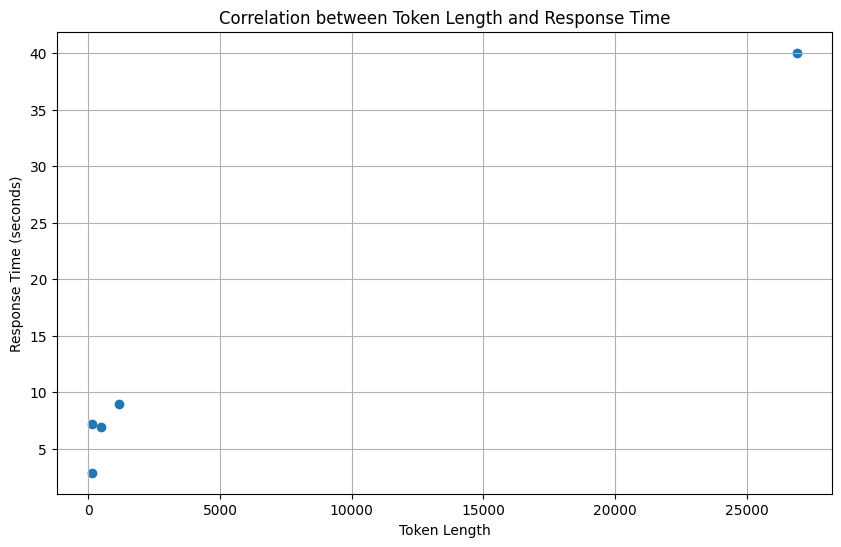

In [106]:
# prompt: buatkan chart korelasi panjang token dengan waktu response

import matplotlib.pyplot as plt

# Assuming df_evaluation is your DataFrame
# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_evaluation["Generated Output"].str.len(), df_evaluation["Time"])
plt.xlabel("Token Length")
plt.ylabel("Response Time (seconds)")
plt.title("Correlation between Token Length and Response Time")
plt.grid(True)
plt.show()


### Deploying the Agent on Vertex AI

Before deploying the agent, we are going to grant excessive permissions for the agent first. Ideally, you should only grant the permissions that are required by the agent. But just to make sure that the agent is able to run without any issues, we are going to grant all the permissions for now. :p

In [ ]:
# Retrieve the project number associated with your project ID
from googleapiclient import discovery
service = discovery.build("cloudresourcemanager", "v1")
request = service.projects().get(projectId=project_id)
response = request.execute()
project_number = response["projectNumber"]
project_number

'644240883738'

In [ ]:
!gcloud projects add-iam-policy-binding {project_id} \
    --member=serviceAccount:service-{project_number}@gcp-sa-aiplatform-re.iam.gserviceaccount.com \
    --role="roles/serviceusage.serviceUsageConsumer"

!gcloud projects add-iam-policy-binding {project_id} \
    --member=serviceAccount:service-{project_number}@gcp-sa-aiplatform-re.iam.gserviceaccount.com \
    --role="roles/discoveryengine.editor"

!gcloud projects add-iam-policy-binding {project_id} \
    --member=serviceAccount:service-{project_number}@gcp-sa-aiplatform-re.iam.gserviceaccount.com \
    --role="roles/cloudsql.admin"

!gcloud projects add-iam-policy-binding {project_id} \
    --member=serviceAccount:service-{project_number}@gcp-sa-aiplatform-re.iam.gserviceaccount.com \
    --role="roles/aiplatform.admin"

!gcloud projects add-iam-policy-binding {project_id} \
    --member=serviceAccount:service-{project_number}@gcp-sa-aiplatform-re.iam.gserviceaccount.com \
    --role="roles/aiplatform.user"

Updated IAM policy for project [agent-rag-451702].
bindings:
- members:
  - serviceAccount:service-644240883738@gcp-sa-artifactregistry.iam.gserviceaccount.com
  role: roles/artifactregistry.serviceAgent
- members:
  - serviceAccount:644240883738-compute@developer.gserviceaccount.com
  - serviceAccount:644240883738@cloudbuild.gserviceaccount.com
  role: roles/cloudbuild.builds.builder
- members:
  - serviceAccount:service-644240883738@gcp-sa-cloudbuild.iam.gserviceaccount.com
  role: roles/cloudbuild.serviceAgent
- members:
  - user:sugengdcahyo@gmail.com
  role: roles/cloudsql.client
- members:
  - serviceAccount:service-644240883738@compute-system.iam.gserviceaccount.com
  role: roles/compute.serviceAgent
- members:
  - serviceAccount:service-644240883738@containerregistry.iam.gserviceaccount.com
  role: roles/containerregistry.ServiceAgent
- members:
  - serviceAccount:644240883738-compute@developer.gserviceaccount.com
  - serviceAccount:644240883738@cloudservices.gserviceaccount.co

#### Deploying to reasoning engine

Deploying is as simple as calling `create()` method. We will provide the agent here and some dependencies required to run the agent.

In [ ]:
remote_agent = reasoning_engines.ReasoningEngine.create(
    agent,
    requirements=[
        "google-cloud-aiplatform",
        "google-cloud-aiplatform[langchain]",
        "google-cloud-aiplatform[reasoningengine]",
        "langchain",
        "langchain_core",
        "langchain_community",
        "langchain-google-vertexai==2.0.8",
        "cloudpickle",
        "pydantic==2.9.2",
        "langchain-google-community",
        "google-cloud-discoveryengine",
        "nest-asyncio",
        "asyncio==3.4.3",
        "asyncpg==0.29.0",
        "cloud-sql-python-connector[asyncpg]",
        "langchain-google-cloud-sql-pg",
        "numpy",
        "pandas",
        "pgvector",
        "psycopg2-binary",
        "google-cloud-trace"
    ],
    display_name="course-agent",
    sys_version="3.11",

)
remote_agent


INFO:vertexai.reasoning_engines._reasoning_engines:Using bucket devfest24-demo-bucket
INFO:vertexai.reasoning_engines._reasoning_engines:Writing to gs://devfest24-demo-bucket/reasoning_engine/reasoning_engine.pkl
INFO:vertexai.reasoning_engines._reasoning_engines:Writing to gs://devfest24-demo-bucket/reasoning_engine/requirements.txt
INFO:vertexai.reasoning_engines._reasoning_engines:Creating in-memory tarfile of extra_packages
INFO:vertexai.reasoning_engines._reasoning_engines:Writing to gs://devfest24-demo-bucket/reasoning_engine/dependencies.tar.gz
INFO:vertexai.reasoning_engines._reasoning_engines:Creating ReasoningEngine
INFO:vertexai.reasoning_engines._reasoning_engines:Create ReasoningEngine backing LRO: projects/644240883738/locations/us-central1/reasoningEngines/3489427694095958016/operations/1003159121731518464


KeyboardInterrupt: 

### Testing Remote Agent

In [ ]:
from vertexai.preview import reasoning_engines

reasoning_engines.ReasoningEngine.list()
# remote_agent = reasoning_engines.ReasoningEngine("projects/908311267620/locations/us-central1/reasoningEngines/7151100481752793088")


In [ ]:
import uuid

# Generate a UUID for the session ID
session_id = str(uuid.uuid4())
print(f"Generated session ID: {session_id}")

In [ ]:
# Testing the remote agent
response = remote_agent.query(
  input="Can you please share what are being taught on this course",
  session_id=session_id,
)
display(Markdown(response["output"]))

In [ ]:
# Testing the remote agent
response = remote_agent.query(
  input="Does it teach about how to design a forgot password system securely?",
  session_id=session_id,
)
display(Markdown(response["output"]))

In [ ]:
# Testing the remote agent
response = remote_agent.query(
  input="How much this course costs?",
  session_id=session_id,
)
display(Markdown(response["output"]))

In [ ]:
# Testing the remote agent
response = remote_agent.query(
  input="Yes. I want to enroll",
  session_id=session_id,
)
display(Markdown(response["output"]))

In [ ]:
# Testing the remote agent
response = remote_agent.query(
  input="Name is Mulyono and email is mulyono@gmail.com",
  session_id=session_id,
)
display(Markdown(response["output"]))

In [ ]:
# Testing the remote agent
response = remote_agent.query(
  input="I have made the payment. Can you please check?",
  session_id=session_id,
)
display(Markdown(response["output"]))